## 1. Install and Import Dependencies

If dependencies are not installed, run first:
```
pip install diffusers transformers accelerate datasets
```

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Check GPU
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")
for i in range(torch.cuda.device_count()):
    print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")
    print(f"    Memory: {torch.cuda.get_device_properties(i).total_memory / 1e9:.1f} GB")

CUDA available: True
Number of GPUs: 2
  GPU 0: NVIDIA A100-SXM4-80GB
    Memory: 85.1 GB
  GPU 1: NVIDIA A100-SXM4-80GB
    Memory: 85.1 GB


## 2. Download and Load CelebA-HQ Dataset

We load the CelebA-HQ dataset first. This dataset serves as the **Target Distribution** for KSWGD and the **Ground Truth** for LDM's evaluation (FID). By loading it here, we ensure both methods are compared against the same data source.

In [2]:
# Download CelebA-HQ to data/ folder
import subprocess
import sys
import os

try:
    from datasets import load_dataset
except ImportError:
    print("Installing datasets library...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "datasets", "-q"])
    from datasets import load_dataset

from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

# Set data directory (alongside MNIST, CIFAR-10)
DATA_DIR = "/workspace/kswgd/data"
CELEBAHQ_CACHE = os.path.join(DATA_DIR, "CelebA-HQ")
os.makedirs(CELEBAHQ_CACHE, exist_ok=True)

print(f"Data directory: {DATA_DIR}")
print(f"CelebA-HQ cache directory: {CELEBAHQ_CACHE}")

# Download CelebA-HQ dataset to data/ folder
# Try multiple possible dataset sources
print("\nDownloading CelebA-HQ dataset...")
print("Data will be saved to data/CelebA-HQ/ folder")

dataset_sources = [
    "mattymchen/celeba-hq",           # Alternative source 1
    "datasets-community/CelebA-HQ",   # Alternative source 2
    "xinrongzhang2022/celeba-hq",     # Alternative source 3
]

celebahq_dataset = None
for source in dataset_sources:
    try:
        print(f"Trying to load: {source}")
        celebahq_dataset = load_dataset(
            source, 
            split="train",
            cache_dir=CELEBAHQ_CACHE,
            trust_remote_code=True
        )
        print(f"✓ Successfully loaded: {source}")
        break
    except Exception as e:
        print(f"✗ Failed to load: {e}")
        continue

if celebahq_dataset is None:
    raise RuntimeError("Unable to load CelebA-HQ dataset, please check network connection or download manually")

print(f"\n✓ CelebA-HQ loaded!")
print(f"  Save location: {CELEBAHQ_CACHE}")
print(f"  Total available samples: {len(celebahq_dataset)}")

/workspace/kswgd_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'mattymchen/celeba-hq' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Data directory: /workspace/kswgd/data
CelebA-HQ cache directory: /workspace/kswgd/data/CelebA-HQ

Data will be saved to data/CelebA-HQ/ folder
Trying to load: mattymchen/celeba-hq
✓ Successfully loaded: mattymchen/celeba-hq

✓ CelebA-HQ loaded!
  Save location: /workspace/kswgd/data/CelebA-HQ
  Total available samples: 28000


## 3. Load Pretrained Unconditional Latent Diffusion Model

Using `CompVis/ldm-celebahq-256`, an **unconditional** Latent Diffusion Model (LDM) trained on CelebA-HQ.

**LDM Architecture:**
- VAE: Image ↔ Latent Space
- UNet: Denoising in Latent Space (unconditional)

In [3]:
from diffusers import DiffusionPipeline

# Load Unconditional Latent Diffusion Model (LDM)
# This is a true unconditional model working in latent space
print("Loading Unconditional LDM (CompVis/ldm-celebahq-256)...")
print("This is an unconditional Latent Diffusion Model trained on CelebA-HQ")

ldm_pipe = DiffusionPipeline.from_pretrained("CompVis/ldm-celebahq-256")
ldm_pipe = ldm_pipe.to("cuda")

# Fix VQ-VAE scaling factor for proper image generation
# The default scaling_factor may cause color/brightness issues
ldm_pipe.vqvae.config.scaling_factor = 1.0

print("\n✓ Unconditional LDM loaded!")
print(f"  Model: CompVis/ldm-celebahq-256")
print(f"  Output size: 256×256")
print(f"  Latent Space: Yes (VAE)")
print(f"  VAE scaling factor: {ldm_pipe.vqvae.config.scaling_factor}")
print(f"  Generation: Pure unconditional, no condition input required")

Loading Unconditional LDM (CompVis/ldm-celebahq-256)...
This is an unconditional Latent Diffusion Model trained on CelebA-HQ


Loading pipeline components...:  33%|███▎      | 1/3 [00:00<00:00,  6.22it/s]An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--ldm-celebahq-256/snapshots/03978f22272a3c2502da709c3940e227c9714bdd/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--ldm-celebahq-256/snapshots/03978f22272a3c2502da709c3940e227c9714bdd/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...:  67%|██████▋   | 2/3 [00:00<00:00,  3.51it/s]An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--ldm-celebahq-256/snapshots/03978f22272a3c2502da709c3940e227c9714bdd/vqvae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--ldm-celebahq-256/snapshots/03978f22272a3c2502da709c3940e227c9714bdd/vqvae.
Defaulting to unsafe serialization. Pass `all


✓ Unconditional LDM loaded!
  Model: CompVis/ldm-celebahq-256
  Output size: 256×256
  Latent Space: Yes (VAE)
  VAE scaling factor: 1.0
  Generation: Pure unconditional, no condition input required


## 3.1 Extract LDM's VAE

Directly use LDM's built-in VAE to maintain consistent latent space. The VAE is pre-trained as part of the LDM, so we demonstrate its reconstruction quality here before proceeding with image generation.

In [4]:
# Directly use LDM's built-in VAE
# This way KSWGD and LDM use exactly the same latent space

print("Extracting LDM's VAE...")

# LDM pipeline contains vqvae (VQ-VAE)
vae = ldm_pipe.vqvae
vae_scaling = 1.0  # LDM's VQ-VAE doesn't need extra scaling

print(f"\n✓ VAE extracted!")
print(f"  Source: LDM's built-in VQ-VAE")
print(f"  Scaling factor: {vae_scaling}")
print(f"  Advantage: KSWGD and LDM share the same latent space")

# VAE helper functions
def _to_vae_range(x):
    """[0,1] → [-1,1]"""
    return (x * 2.0) - 1.0

def _from_vae_range(x):
    """[-1,1] → [0,1]"""
    return torch.clamp((x + 1.0) * 0.5, 0.0, 1.0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Extracting LDM's VAE...

✓ VAE extracted!
  Source: LDM's built-in VQ-VAE
  Scaling factor: 1.0
  Advantage: KSWGD and LDM share the same latent space


=== VAE Reconstruction Quality Test ===

Dataset size: 28000 CelebA-HQ images
Test samples: 5
Sampling method: Random sampling
VAE source: LDM pretrained model built-in VQ-VAE
Test purpose: Validate VAE encode→decode reconstruction quality

Using pure random (no seed)
Randomly selected sample indices: [9717, 10319, 10635, 1660, 27268]


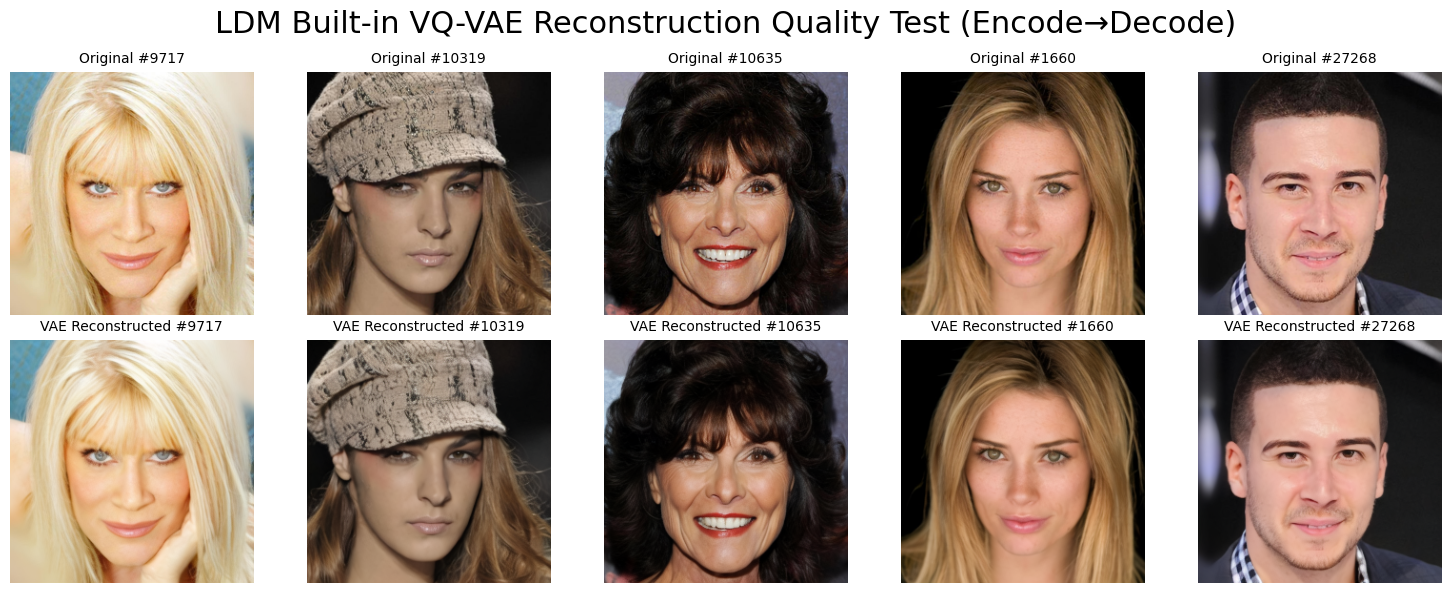


✓ VAE reconstruction test complete!
📊 Evaluation metric: Visual comparison of original vs reconstructed images
🎯 Good reconstruction quality → VAE can accurately preserve and recover image information
⚠️  Poor reconstruction quality → May affect subsequent KSWGD generation quality

💡 Want to see different images?
   - Comment out RANDOM_SEED for pure random sampling
   - Set RANDOM_SEED to different values for reproducible results
   - Or simply re-run this cell


In [5]:
# Test VAE reconstruction on real images
# 🔍 VAE Quality Test: Demonstrate LDM's built-in VQ-VAE reconstruction capability
# VAE Source: Built-in VQ-VAE from CompVis/ldm-celebahq-256 pretrained model

import random

# ============== Sampling Settings ==============
n_recon = 5
USE_RANDOM_SAMPLES = True  # True: random sampling, False: first n_recon samples
# RANDOM_SEED = 42  # Set random seed for reproducible results (comment out for pure random)
# ==============================================

print(f"=== VAE Reconstruction Quality Test ===\n")
print(f"Dataset size: {len(celebahq_dataset)} CelebA-HQ images")
print(f"Test samples: {n_recon}")
print(f"Sampling method: {'Random sampling' if USE_RANDOM_SAMPLES else 'First '+str(n_recon)+' samples'}")
print(f"VAE source: LDM pretrained model built-in VQ-VAE")
print(f"Test purpose: Validate VAE encode→decode reconstruction quality\n")

# Select test samples
if USE_RANDOM_SAMPLES:
    # Check if RANDOM_SEED is defined, if not use pure random
    if 'RANDOM_SEED' in locals():
        random.seed(RANDOM_SEED)
        print(f"Using random seed: {RANDOM_SEED}")
    else:
        print("Using pure random (no seed)")
    
    test_indices = random.sample(range(len(celebahq_dataset)), n_recon)
    print(f"Randomly selected sample indices: {test_indices}")
else:
    test_indices = list(range(n_recon))
    print(f"Fixed sample indices: {test_indices}")

fig, axes = plt.subplots(2, n_recon, figsize=(15, 6))

vae.eval()
with torch.no_grad():
    for plot_idx, sample_idx in enumerate(test_indices):
        # Original
        img = celebahq_dataset[sample_idx]["image"]
        img_tensor = T.Compose([T.Resize((256, 256)), T.ToTensor()])(img).unsqueeze(0).to(device)
        
        # Encode & Decode
        latent = vae.encode(_to_vae_range(img_tensor))
        
        if hasattr(latent, 'latents'):
            latent_code = latent.latents
        elif hasattr(latent, 'latent_dist'):
            latent_code = latent.latent_dist.mode()
        else:
            latent_code = latent[0] if isinstance(latent, tuple) else latent
            
        recon = vae.decode(latent_code).sample
        recon_img = _from_vae_range(recon).cpu().squeeze(0).permute(1, 2, 0).numpy()
        
        # Plot
        axes[0, plot_idx].imshow(np.array(img.resize((256, 256))))
        axes[0, plot_idx].set_title(f"Original #{sample_idx}", fontsize=10)
        axes[0, plot_idx].axis('off')
        
        axes[1, plot_idx].imshow(recon_img)
        axes[1, plot_idx].set_title(f"VAE Reconstructed #{sample_idx}", fontsize=10)
        axes[1, plot_idx].axis('off')

plt.suptitle("LDM Built-in VQ-VAE Reconstruction Quality Test (Encode→Decode)", fontsize=22)
plt.tight_layout()
plt.show()

print(f"\n✓ VAE reconstruction test complete!")
print(f"📊 Evaluation metric: Visual comparison of original vs reconstructed images")
print(f"🎯 Good reconstruction quality → VAE can accurately preserve and recover image information")
print(f"⚠️  Poor reconstruction quality → May affect subsequent KSWGD generation quality")
print(f"\n💡 Want to see different images?")
print(f"   - Comment out RANDOM_SEED for pure random sampling")
print(f"   - Set RANDOM_SEED to different values for reproducible results")
print(f"   - Or simply re-run this cell")

## 4. Batch Unconditional LDM Generation

Detected 2 GPU(s) for LDM generation
Mode: Dual-GPU parallel
Generating 2 unconditional LDM images (batch_size=64)...
This will take a while...
  GPU 0: 1 images
  GPU 1: 1 images
Loading LDM on GPU 1...


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]The config attributes {'timestep_values': None, 'timesteps': 1000} were passed to DDIMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--ldm-celebahq-256/snapshots/03978f22272a3c2502da709c3940e227c9714bdd/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--ldm-celebahq-256/snapshots/03978f22272a3c2502da709c3940e227c9714bdd/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...:  67%|██████▋   | 2/3 [00:00<00:00, 17.52it/s]An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--ldm-celebahq-256/snapshots/03978f22272a3c2502da709c3940e227c9714bdd/vqvae: Error no file named diffusion_pytorch_model.safet


✓ LDM generation complete!
Total images: 2
Total time: 17.7 seconds (0.3 minutes)
Average per image: 8.84 seconds
Speedup: ~2.0x (dual-GPU parallel)


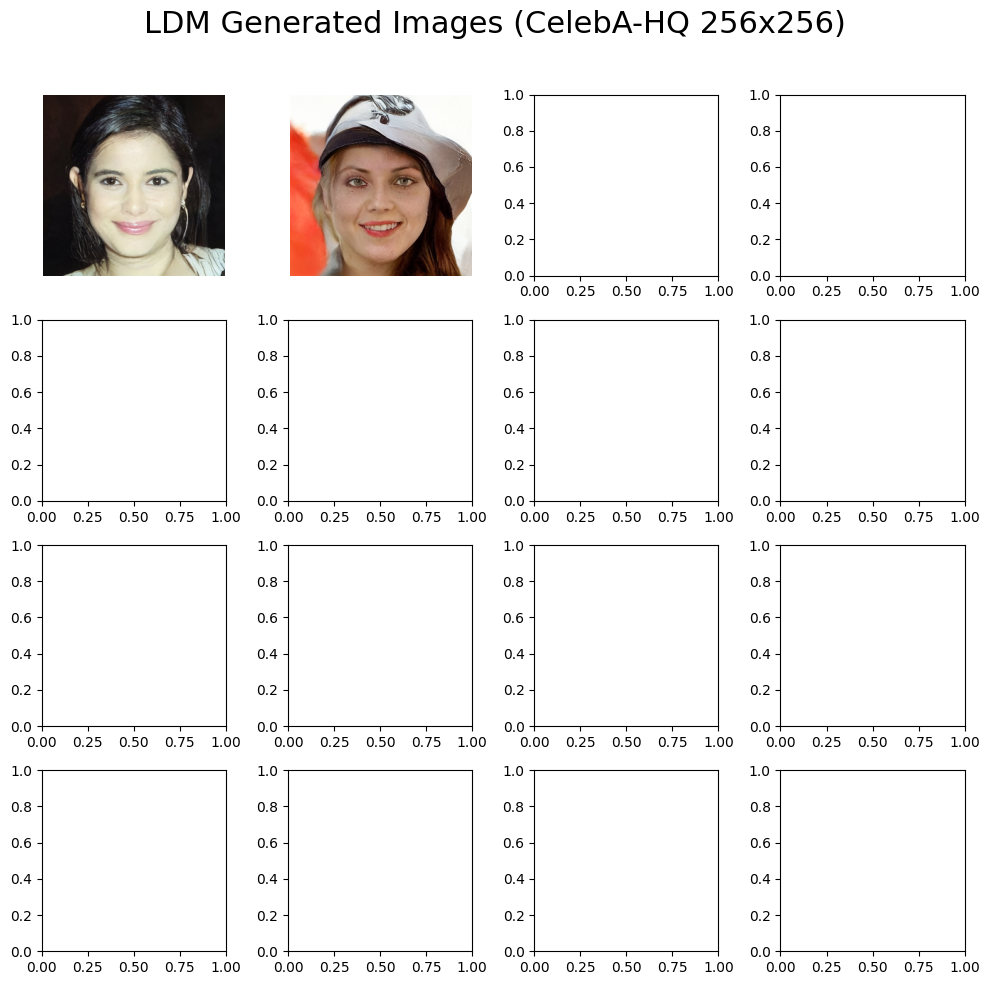

In [6]:
import time
from tqdm.auto import tqdm
from concurrent.futures import ThreadPoolExecutor

# Batch generate multiple unconditional images
n_generate = 2  # Generate 5000 images for development testing (reliable FID)
batch_size = 64    # Generate in batches (increased for 80GB GPUs)

# Check if dual-GPU is available for LDM generation
NUM_GPUS_LDM = torch.cuda.device_count()
USE_DUAL_GPU_LDM = NUM_GPUS_LDM >= 2

print(f"Detected {NUM_GPUS_LDM} GPU(s) for LDM generation")
print(f"Mode: {'Dual-GPU parallel' if USE_DUAL_GPU_LDM else 'Single-GPU'}")
print(f"Generating {n_generate} unconditional LDM images (batch_size={batch_size})...")
print(f"This will take a while...")

start_time = time.time()

if USE_DUAL_GPU_LDM:
    # ============== Dual-GPU LDM Generation ==============
    from diffusers import DiffusionPipeline
    
    # Calculate split: each GPU generates half
    n_gpu0 = n_generate // 2
    n_gpu1 = n_generate - n_gpu0
    
    print(f"  GPU 0: {n_gpu0} images")
    print(f"  GPU 1: {n_gpu1} images")
    
    # Load LDM on GPU 1 (GPU 0 already has ldm_pipe)
    print("Loading LDM on GPU 1...")
    ldm_pipe_gpu1 = DiffusionPipeline.from_pretrained("CompVis/ldm-celebahq-256")
    ldm_pipe_gpu1 = ldm_pipe_gpu1.to("cuda:1")
    ldm_pipe_gpu1.vqvae.config.scaling_factor = 1.0
    ldm_pipe_gpu1.set_progress_bar_config(disable=True)
    
    # Also disable progress bar for GPU 0
    ldm_pipe.set_progress_bar_config(disable=True)
    
    def generate_on_gpu(pipe, n_images, batch_size, gpu_id):
        """Generate images on a specific GPU"""
        images = []
        n_batches = (n_images + batch_size - 1) // batch_size
        
        for batch_idx in tqdm(range(n_batches), desc=f"LDM (GPU {gpu_id})"):
            current_batch_size = min(batch_size, n_images - batch_idx * batch_size)
            result = pipe(
                batch_size=current_batch_size,
                num_inference_steps=500,
            )
            images.extend(result.images)
            
            # Clear cache periodically
            if (batch_idx + 1) % 20 == 0:
                torch.cuda.empty_cache()
        
        return images
    
    # Run both GPUs in parallel using ThreadPoolExecutor
    with ThreadPoolExecutor(max_workers=2) as executor:
        future_gpu0 = executor.submit(generate_on_gpu, ldm_pipe, n_gpu0, batch_size, 0)
        future_gpu1 = executor.submit(generate_on_gpu, ldm_pipe_gpu1, n_gpu1, batch_size, 1)
        
        images_gpu0 = future_gpu0.result()
        images_gpu1 = future_gpu1.result()
    
    # Combine results
    ldm_generated_images = images_gpu0 + images_gpu1
    
    # Clean up GPU 1 pipeline to free memory
    del ldm_pipe_gpu1
    torch.cuda.empty_cache()
    
else:
    # ============== Single-GPU LDM Generation ==============
    ldm_pipe.set_progress_bar_config(disable=True)
    
    ldm_generated_images = []
    n_batches = (n_generate + batch_size - 1) // batch_size

    for batch_idx in tqdm(range(n_batches), desc="LDM Generation"):
        current_batch_size = min(batch_size, n_generate - batch_idx * batch_size)
        result = ldm_pipe(
            batch_size=current_batch_size,
            num_inference_steps=500,
        )
        ldm_generated_images.extend(result.images)
        
        # Clear cache periodically
        if (batch_idx + 1) % 50 == 0:
            torch.cuda.empty_cache()

elapsed = time.time() - start_time
print(f"\n✓ LDM generation complete!")
print(f"Total images: {len(ldm_generated_images)}")
print(f"Total time: {elapsed:.1f} seconds ({elapsed/60:.1f} minutes)")
print(f"Average per image: {elapsed/len(ldm_generated_images):.2f} seconds")
if USE_DUAL_GPU_LDM:
    print(f"Speedup: ~{2.0:.1f}x (dual-GPU parallel)")

# Visualization (show first 16)
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

for idx in range(min(16, len(ldm_generated_images))):
    axes[idx].imshow(ldm_generated_images[idx])
    # axes[idx].set_title(f"#{idx+1}")
    axes[idx].axis('off')

# Get image size from generated images
_ldm_img_size = ldm_generated_images[0].size[0] if hasattr(ldm_generated_images[0], 'size') else 256
plt.suptitle(f"LDM Generated Images (CelebA-HQ {_ldm_img_size}x{_ldm_img_size})", fontsize=22, y=0.98)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 4.1 Super-Resolution (Real-ESRGAN)

The native output of LDM is 256x256. To match the visual quality of high-resolution papers, we apply **Real-ESRGAN** super-resolution to upscale images to 1024x1024.

This is **Method A** - the same approach used in many diffusion model papers for high-quality output.

Detected 2 GPU(s), using Dual-GPU mode for upscaling
Initializing Real-ESRGAN + GFPGAN...


/workspace/kswgd_env/lib/python3.11/site-packages/realesrgan/utils.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loadnet = torch.load(model_path, map_location=torch.d

  ✓ GPU 0: Real-ESRGAN + GFPGAN initialized
  ✓ GPU 1: Real-ESRGAN + GFPGAN initialized
✓ Upscalers initialized!
  - Real-ESRGAN: 4x basic upscale
  - GFPGAN: 4x upscale + face enhancement + color correction
  - Preprocessing: Gaussian blur + Bilateral filter + Color normalization
  - Mode: Dual-GPU parallel

Upscaling LDM Generated Images with GFPGAN
(with preprocessing: Gaussian + Bilateral + Color Norm)

Enhancing 2 LDM images with preprocessing + GFPGAN...
  Using Dual-GPU parallel processing...


Preprocess+GFPGAN (GPU 1): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


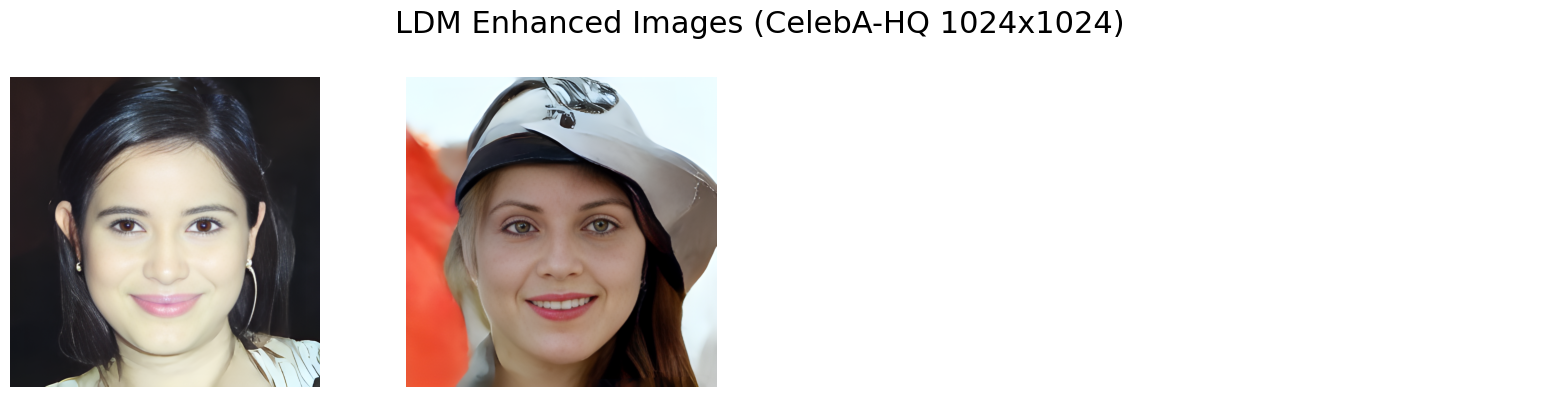


✓ Enhancement complete!
  Original LDM: 256x256
  Enhanced: 1024x1024
  Preprocessing applied: Gaussian blur (3x3, σ=0.5) + Bilateral (d=5) + Color norm (α=0.3)


In [7]:
# Real-ESRGAN + GFPGAN Super-Resolution Setup (Dual-GPU Support)
import os
import cv2
from concurrent.futures import ThreadPoolExecutor
from basicsr.archs.rrdbnet_arch import RRDBNet
from realesrgan import RealESRGANer
from gfpgan import GFPGANer

# Create figures directory if not exists
os.makedirs('/workspace/kswgd/figures', exist_ok=True)

# Check number of GPUs
NUM_GPUS = torch.cuda.device_count()
USE_DUAL_GPU = NUM_GPUS >= 2
print(f"Detected {NUM_GPUS} GPU(s), using {'Dual-GPU' if USE_DUAL_GPU else 'Single-GPU'} mode for upscaling")

# Initialize Real-ESRGAN and GFPGAN for each GPU
model_path = '/workspace/kswgd/weights/RealESRGAN_x4plus.pth'
gfpgan_path = '/workspace/kswgd/weights/GFPGANv1.3.pth'

def create_upscaler(gpu_id):
    """Create Real-ESRGAN + GFPGAN instances on specified GPU"""
    model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4)
    upsampler = RealESRGANer(
        scale=4,
        model_path=model_path,
        model=model,
        tile=0,
        tile_pad=10,
        pre_pad=0,
        half=True,
        gpu_id=gpu_id
    )
    face_enhancer = GFPGANer(
        model_path=gfpgan_path,
        upscale=4,
        arch='clean',
        channel_multiplier=2,
        bg_upsampler=upsampler
    )
    return upsampler, face_enhancer

print("Initializing Real-ESRGAN + GFPGAN...")
if USE_DUAL_GPU:
    # Create instances on both GPUs
    upsampler_0, face_enhancer_0 = create_upscaler(0)
    upsampler_1, face_enhancer_1 = create_upscaler(1)
    upsamplers = [upsampler_0, upsampler_1]
    face_enhancers = [face_enhancer_0, face_enhancer_1]
    print(f"  ✓ GPU 0: Real-ESRGAN + GFPGAN initialized")
    print(f"  ✓ GPU 1: Real-ESRGAN + GFPGAN initialized")
else:
    # Single GPU mode
    upsampler_0, face_enhancer_0 = create_upscaler(0)
    upsamplers = [upsampler_0]
    face_enhancers = [face_enhancer_0]
    print(f"  ✓ GPU 0: Real-ESRGAN + GFPGAN initialized")

def preprocess_image(img_bgr, use_gaussian=True, use_bilateral=True, use_color_norm=True):
    """
    Apply preprocessing before GFPGAN:
    1. Gaussian blur - reduce noise
    2. Bilateral filter - edge-preserving smoothing
    3. Color normalization - adjust color distribution (mean normalization)
    """
    processed = img_bgr.copy().astype(np.float32)
    
    # 1. Gaussian Blur (slight smoothing, small kernel size)
    if use_gaussian:
        processed = cv2.GaussianBlur(processed, (3, 3), sigmaX=0.5)
    
    # 2. Bilateral Filter (edge-preserving smoothing)
    if use_bilateral:
        processed = cv2.bilateralFilter(processed.astype(np.uint8), d=5, sigmaColor=30, sigmaSpace=30).astype(np.float32)
    
    # 3. Color Normalization (color space mean normalization)
    if use_color_norm:
        mean_b = np.mean(processed[:, :, 0])
        mean_g = np.mean(processed[:, :, 1])
        mean_r = np.mean(processed[:, :, 2])
        target_mean = 127.5
        alpha = 0.3
        processed[:, :, 0] = processed[:, :, 0] + alpha * (target_mean - mean_b)
        processed[:, :, 1] = processed[:, :, 1] + alpha * (target_mean - mean_g)
        processed[:, :, 2] = processed[:, :, 2] + alpha * (target_mean - mean_r)
        processed = np.clip(processed, 0, 255)
    
    return processed.astype(np.uint8)

def process_single_image(args):
    """Process a single image with specified GPU"""
    img, gpu_id, use_face_enhance, use_preprocess = args
    face_enhancer = face_enhancers[gpu_id]
    upsampler = upsamplers[gpu_id]
    
    if isinstance(img, Image.Image):
        img_np = np.array(img)
    else:
        if img.ndim == 3 and img.shape[0] == 3:
            img_np = np.transpose(img, (1, 2, 0))
        else:
            img_np = img
        if img_np.max() <= 1.0:
            img_np = (img_np * 255).astype(np.uint8)
    
    img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
    
    if use_preprocess:
        img_bgr = preprocess_image(img_bgr, use_gaussian=True, use_bilateral=True, use_color_norm=True)
    
    if use_face_enhance:
        _, _, output_bgr = face_enhancer.enhance(img_bgr, has_aligned=False, only_center_face=False, paste_back=True)
    else:
        output_bgr, _ = upsampler.enhance(img_bgr, outscale=4)
    
    output_rgb = cv2.cvtColor(output_bgr, cv2.COLOR_BGR2RGB)
    return output_rgb

def upscale_images(images_list, use_face_enhance=True, use_preprocess=True, desc="Upscaling"):
    """
    Upscale images using GFPGAN (face enhancement) or Real-ESRGAN (basic upscale).
    Automatically uses dual-GPU parallel processing if available.
    """
    n_images = len(images_list)
    
    if USE_DUAL_GPU and n_images >= 2:
        # Dual-GPU parallel processing
        print(f"  Using Dual-GPU parallel processing...")
        mid = n_images // 2
        
        # Assign images to GPUs: first half to GPU 0, second half to GPU 1
        args_gpu0 = [(img, 0, use_face_enhance, use_preprocess) for img in images_list[:mid]]
        args_gpu1 = [(img, 1, use_face_enhance, use_preprocess) for img in images_list[mid:]]
        
        results_gpu0 = []
        results_gpu1 = []
        
        # Use ThreadPoolExecutor to run both GPUs in parallel
        with ThreadPoolExecutor(max_workers=2) as executor:
            # Submit GPU 0 batch
            future_gpu0 = executor.submit(
                lambda args_list: [process_single_image(args) for args in tqdm(args_list, desc=f"{desc} (GPU 0)")],
                args_gpu0
            )
            # Submit GPU 1 batch  
            future_gpu1 = executor.submit(
                lambda args_list: [process_single_image(args) for args in tqdm(args_list, desc=f"{desc} (GPU 1)")],
                args_gpu1
            )
            
            results_gpu0 = future_gpu0.result()
            results_gpu1 = future_gpu1.result()
        
        # Combine results in original order
        upscaled_images = results_gpu0 + results_gpu1
    else:
        # Single-GPU processing
        upscaled_images = []
        for img in tqdm(images_list, desc=desc):
            result = process_single_image((img, 0, use_face_enhance, use_preprocess))
            upscaled_images.append(result)
    
    return upscaled_images

print("✓ Upscalers initialized!")
print(f"  - Real-ESRGAN: 4x basic upscale")
print(f"  - GFPGAN: 4x upscale + face enhancement + color correction")
print(f"  - Preprocessing: Gaussian blur + Bilateral filter + Color normalization")
print(f"  - Mode: {'Dual-GPU parallel' if USE_DUAL_GPU else 'Single-GPU sequential'}")

# ============== Upscale LDM Generated Images ==============
print("\n" + "=" * 60)
print("Upscaling LDM Generated Images with GFPGAN")
print("(with preprocessing: Gaussian + Bilateral + Color Norm)")
print("=" * 60)

# Use all generated images from previous cell
n_test = len(ldm_generated_images)
print(f"\nEnhancing {n_test} LDM images with preprocessing + GFPGAN...")
ldm_enhanced = upscale_images(ldm_generated_images, use_face_enhance=True, use_preprocess=True, desc="Preprocess+GFPGAN")

# Visualization (show up to 16 in a grid)
n_show = min(16, n_test)
n_cols = 4
n_rows = (n_show + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = np.asarray(axes).reshape(-1)

for i in range(n_show):
    axes[i].imshow(ldm_enhanced[i])
    # axes[i].set_title(f"#{i+1}")
    axes[i].axis('off')

for i in range(n_show, len(axes)):
    axes[i].axis('off')

# Get image size from enhanced images
_ldm_enhanced_size = ldm_enhanced[0].shape[1] if isinstance(ldm_enhanced[0], np.ndarray) else ldm_enhanced[0].size[0]
plt.suptitle(f"LDM Enhanced Images (CelebA-HQ {_ldm_enhanced_size}x{_ldm_enhanced_size})", fontsize=22, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('/workspace/kswgd/figures/ldm_gfpgan_enhanced.png', dpi=150, bbox_inches='tight')
plt.show()

# Store enhanced images for later use
ldm_upscaled = ldm_enhanced

print(f"\n✓ Enhancement complete!")
print(f"  Original LDM: 256x256")
print(f"  Enhanced: {ldm_upscaled[0].shape[1]}x{ldm_upscaled[0].shape[0]}")
print(f"  Preprocessing applied: Gaussian blur (3x3, σ=0.5) + Bilateral (d=5) + Color norm (α=0.3)")

In [8]:
# Section 6.5: Memory Cleanup
# To avoid OOM during KSWGD, we release the LDM UNet and other components that are no longer needed.
import gc

print(f"GPU Memory before cleanup: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

if 'ldm_pipe' in globals():
    # We only need the VAE for KSWGD, so we can release the UNet (the largest part)
    # This can free up 2-4 GB of VRAM.
    print("Releasing LDM UNet and other components...")
    if hasattr(ldm_pipe, 'unet'):
        ldm_pipe.unet = None
    if hasattr(ldm_pipe, 'text_encoder'):
        ldm_pipe.text_encoder = None
    if hasattr(ldm_pipe, 'scheduler'):
        ldm_pipe.scheduler = None
    
gc.collect()
torch.cuda.empty_cache()

print(f"GPU Memory after cleanup: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

GPU Memory before cleanup: 2.51 GB
Releasing LDM UNet and other components...
GPU Memory after cleanup: 1.40 GB


## 7. KSWGD Unconditional Generation (Core Experiment)

Using KSWGD (Koopman Spectral Wasserstein Gradient Descent) to perform **unconditional** particle transport generation in latent space.

**Unconditional Pipeline:**
```
Training Data (CelebA-HQ) → VAE Encoder → Latent Z_tar (Target Distribution Samples)
                                              ↓
Random Noise N(0,1) → KSWGD Transport → Z_gen (Unconditional Generation)
                                              ↓
                                   VAE Decoder → Generated Image
```

**Comparison of Two Unconditional Methods (Fair Comparison, Same Dataset):**
| | LDM (Section 2-4) | KSWGD (Section 7) |
|---|---|---|
| Dataset | CelebA-HQ | CelebA-HQ |
| Generation Process | Random Noise → Denoising | Random Noise → KSWGD |
| Core Component | UNet | Kernel Matrix + Eigendecomposition |
| Condition Input | None | None |
| Iteration Steps | 200 | Adjustable (e.g., 300) |

In [9]:
# Import KSWGD required libraries and custom kernel functions
from sklearn.metrics import pairwise_distances
from tqdm.auto import trange

# Import your kernel functions
from grad_ker1 import grad_ker1
from K_tar_eval import K_tar_eval

# Try to import GPU version
try:
    import cupy as cp
    from grad_ker1_gpu import grad_ker1 as grad_ker1_gpu
    from K_tar_eval_gpu import K_tar_eval as K_tar_eval_gpu
    GPU_KSWGD = True
    print("✓ GPU KSWGD backend available (CuPy)")
except Exception as e:
    cp = None
    grad_ker1_gpu = None
    K_tar_eval_gpu = None
    GPU_KSWGD = False
    print(f"✗ GPU KSWGD backend not available: {e}")
    print("  Using CPU backend instead")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

✓ GPU KSWGD backend available (CuPy)
Device: cuda


In [11]:
# Encode CelebA-HQ images and compress with MLP AutoEncoder
from torchvision import transforms as T
from tqdm.auto import tqdm
import pickle
import os

# Image preprocessing
transform_celebahq = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
])

# ============== MLP Latent Compression Settings ==============
# Use MLP AutoEncoder to compress VAE's 1024-dim latent to lower dimension
REDUCED_DIM = 64  # Target dimension for MLP compression
# =============================================================

# ============== Caching Settings ==============
LOAD_FROM_CACHE = True
CACHE_DIR = "/workspace/kswgd/cache"
os.makedirs(CACHE_DIR, exist_ok=True)
# ==============================================

# ============== MLP Latent AutoEncoder ==============
class LatentAutoEncoder(torch.nn.Module):
    """
    Learnable MLP to compress VAE latent space (1024-dim) to lower dimension.
    """
    def __init__(self, input_dim=1024, latent_dim=64, hidden_dim=256):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Encoder: 1024 -> hidden -> latent_dim
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.LayerNorm(hidden_dim),
            torch.nn.GELU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LayerNorm(hidden_dim),
            torch.nn.GELU(),
            torch.nn.Linear(hidden_dim, latent_dim),
        )
        
        # Decoder: latent_dim -> hidden -> 1024
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, hidden_dim),
            torch.nn.LayerNorm(hidden_dim),
            torch.nn.GELU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LayerNorm(hidden_dim),
            torch.nn.GELU(),
            torch.nn.Linear(hidden_dim, input_dim),
        )
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        z = self.encode(x)
        return self.decode(z), z


def train_latent_autoencoder(Z_flat, latent_dim=64, epochs=100, batch_size=512, lr=1e-3):
    """Train the MLP AutoEncoder on VAE latent codes"""
    print(f"\n=== Training Latent AutoEncoder (1024 -> {latent_dim}) ===")
    
    model = LatentAutoEncoder(input_dim=Z_flat.shape[1], latent_dim=latent_dim).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    # Convert to tensor
    Z_tensor = torch.from_numpy(Z_flat).float().to(device)
    dataset = torch.utils.data.TensorDataset(Z_tensor)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    model.train()
    best_loss = float('inf')
    
    for epoch in range(epochs):
        total_loss = 0.0
        for (batch,) in dataloader:
            optimizer.zero_grad()
            recon, z = model(batch)
            loss = torch.nn.functional.mse_loss(recon, batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.size(0)
        
        avg_loss = total_loss / len(Z_tensor)
        scheduler.step()
        
        if avg_loss < best_loss:
            best_loss = avg_loss
        
        if (epoch + 1) % 20 == 0 or epoch == 0:
            print(f"  Epoch {epoch+1:3d}/{epochs}: Loss = {avg_loss:.6f}")
    
    print(f"✓ Training complete! Best loss: {best_loss:.6f}")
    
    # Encode all data
    model.eval()
    with torch.no_grad():
        Z_reduced = model.encode(Z_tensor).cpu().numpy()
    
    return model, Z_reduced
# ====================================================

max_samples = 28000

# Generate cache filename
cache_path = os.path.join(CACHE_DIR, f"vae_encoding_n{max_samples}_mlp{REDUCED_DIM}.pkl")

# Try to load from cache
if LOAD_FROM_CACHE and os.path.exists(cache_path):
    print(f"Loading VAE encodings from cache: {cache_path}")
    with open(cache_path, 'rb') as f:
        cache_data = pickle.load(f)
    Z_all = cache_data['Z_all']
    latent_dim = cache_data['latent_dim']
    full_latent_shape = cache_data['full_latent_shape']
    latent_ae = cache_data.get('latent_ae')
    
    print(f"✓ Loaded from cache!")
    print(f"  Z_all shape: {Z_all.shape}")
    print(f"  Latent dim: {latent_dim}")
else:
    print(f"Cache not found or disabled. Computing VAE encodings...")
    
    all_latents = []
    vae.eval()
    print(f"Encoding {max_samples} images to latent space...")

    with torch.no_grad():
        for i in tqdm(range(min(max_samples, len(celebahq_dataset))), desc="Encoding"):
            img = celebahq_dataset[i]["image"]
            img_tensor = transform_celebahq(img).unsqueeze(0).to(device)
            
            # Encode to latent
            latent = vae.encode(_to_vae_range(img_tensor))
            latent_code = latent.latents if hasattr(latent, 'latents') else (latent.latent_dist.mode() if hasattr(latent, 'latent_dist') else latent[0])
            latent_code = latent_code * vae_scaling  # (1, 4, 16, 16)
            
            all_latents.append(latent_code.view(1, -1).cpu().numpy())

    Z_flat = np.concatenate(all_latents, axis=0)
    print(f"Latent vectors collected: {Z_flat.shape}")
    
    # ============== Train MLP AutoEncoder ==============
    import time as _time
    print(f"\n Training MLP AutoEncoder (1024 -> {REDUCED_DIM})...")
    _mlp_start = _time.time()
    
    # Train the autoencoder
    latent_ae, Z_all = train_latent_autoencoder(
        Z_flat, 
        latent_dim=REDUCED_DIM, 
        epochs=100,
        batch_size=512,
        lr=1e-3
    )
    latent_dim = Z_all.shape[1]
    
    _mlp_elapsed = _time.time() - _mlp_start
    print(f"\n✓ MLP AutoEncoder complete! Time: {_mlp_elapsed:.2f}s")
    print(f"  Original VAE latent: {Z_flat.shape[1]} dim (4×16×16)")
    print(f"  Compressed latent:   {Z_all.shape[1]} dim")
    
    # Test reconstruction quality
    with torch.no_grad():
        Z_test = torch.from_numpy(Z_flat[:100]).float().to(device)
        Z_recon, _ = latent_ae(Z_test)
        recon_loss = torch.nn.functional.mse_loss(Z_recon, Z_test).item()
        print(f"  Reconstruction MSE (test): {recon_loss:.6f}")

    # Record shapes for decoding
    with torch.no_grad():
        dummy = torch.zeros(1, 3, 256, 256, device=device)
        dummy_latent = vae.encode(_to_vae_range(dummy))
        dummy_code = dummy_latent.latents if hasattr(dummy_latent, 'latents') else (dummy_latent.latent_dist.mode() if hasattr(dummy_latent, 'latent_dist') else dummy_latent[0])
        full_latent_shape = dummy_code.shape[1:]  # (4, 16, 16)

    # Save to cache
    print(f"\nSaving to cache: {cache_path}")
    cache_data = {
        'Z_all': Z_all,
        'latent_dim': latent_dim,
        'latent_ae': latent_ae,
        'full_latent_shape': full_latent_shape,
        'REDUCED_DIM': REDUCED_DIM,
        'max_samples': max_samples
    }
    with open(cache_path, 'wb') as f:
        pickle.dump(cache_data, f)
    print(f"✓ Cache saved!")

print(f"Full Latent Shape: {full_latent_shape}")

Cache not found or disabled. Computing VAE encodings...
Encoding 28000 images to latent space...


Encoding: 100%|██████████| 28000/28000 [11:43<00:00, 39.81it/s]


Latent vectors collected: (28000, 12288)

🧠 Training MLP AutoEncoder (1024 -> 64)...

=== Training Latent AutoEncoder (1024 -> 64) ===
  Epoch   1/100: Loss = 0.775400
  Epoch  20/100: Loss = 0.564847
  Epoch  40/100: Loss = 0.545866
  Epoch  60/100: Loss = 0.540610
  Epoch  80/100: Loss = 0.538384
  Epoch 100/100: Loss = 0.537739
✓ Training complete! Best loss: 0.537739

✓ MLP AutoEncoder complete! Time: 27.22s
  Original VAE latent: 12288 dim (4×16×16)
  Compressed latent:   64 dim
  Reconstruction MSE (test): 0.531281

Saving to cache: /workspace/kswgd/cache/vae_encoding_n28000_mlp64.pkl
✓ Cache saved!
Full Latent Shape: torch.Size([3, 64, 64])


### 7.1 Latent Space Compression with MLP AutoEncoder

We use a **learnable MLP AutoEncoder** to compress the VQ-VAE latent space from 1024 (4×16×16) to 64 dimensions.

**Architecture:**
```
VAE Latent (1024) → MLP Encoder → Compressed (64) → MLP Decoder → VAE Latent (1024)
```

**Why MLP instead of PCA?**
1. **Nonlinear Mapping**: MLP can learn nonlinear projections, preserving more visual details than linear PCA.
2. **Learnable**: The compression is optimized specifically for this dataset's latent distribution.
3. **Efficiency**: KSWGD kernel computation scales as $O(n^2 \cdot d)$, so 64-dim is much faster than 1024-dim.

In [12]:
# Standardize latent codes and build KSWGD kernel operator
# Standardization
Z_mean = np.mean(Z_all, axis=0, keepdims=True)
Z_std = np.std(Z_all, axis=0, keepdims=True) + 1e-8
Z_std = Z_std.astype(np.float64)
Z_mean = Z_mean.astype(np.float64)
X_tar = ((Z_all - Z_mean) / Z_std).astype(np.float64)

print(f"After standardization: mean={X_tar.mean():.4f}, std={X_tar.std():.4f}")

# Compute squared sum of target samples (for kernel function)
sq_tar = np.sum(X_tar ** 2, axis=1)

# Compute pairwise distances and bandwidth epsilon
dists = pairwise_distances(X_tar, metric="euclidean")
eps_kswgd = np.median(dists**2) / (2.0 * np.log(X_tar.shape[0] + 1))
eps_kswgd = float(max(eps_kswgd, 1e-6))

print(f"KSWGD epsilon: {eps_kswgd:.6f}")
print(f"Distance stats: min={dists[dists>0].min():.4f}, median={np.median(dists):.4f}, max={dists.max():.4f}")

# Build data kernel matrix
data_kernel = np.exp(-dists**2 / (2.0 * eps_kswgd))

# Normalization
p_x = np.sqrt(np.sum(data_kernel, axis=1))
data_kernel_norm = data_kernel / (p_x[:, None] * p_x[None, :] + 1e-12)
D_y = np.sum(data_kernel_norm, axis=0)
rw_kernel = 0.5 * (data_kernel_norm / (D_y + 1e-12) + data_kernel_norm / (D_y[:, None] + 1e-12))
rw_kernel = np.nan_to_num(rw_kernel)

print(f"Kernel matrix built, shape: {rw_kernel.shape}")

# latent_dim is already set in the previous cell (Spatial Mean Pooling)
print(f"KSWGD latent_dim: {latent_dim}")

After standardization: mean=0.0000, std=1.0000
KSWGD epsilon: 5.681554
Distance stats: min=0.0000, median=10.7869, max=35.3391
Kernel matrix built, shape: (28000, 28000)
KSWGD latent_dim: 64


In [13]:
# Compute eigendecomposition and KSWGD weights
import time
import threading
from scipy.sparse.linalg import eigsh

print("Computing eigendecomposition...")
start_time = time.time()

# ============== Truncated Eigendecomposition Settings ==============
# k: number of largest eigenvalues to compute
# Using truncated decomposition is much faster for large matrices (e.g., 30000x30000)
k_eig = 300  # Default: compute top 300 eigenvalues (truncated)
# k_eig = rw_kernel.shape[0]  # Uncomment this line to compute ALL eigenvalues (full decomposition)
USE_GPU_EIGSH = True  # Use GPU for truncated eigendecomposition (torch.lobpcg)
# ===================================================================

n_samples = rw_kernel.shape[0]
use_truncated = k_eig < n_samples

# Estimate time based on matrix size
if use_truncated:
    est_time = n_samples * k_eig / 1e7  # Rough estimate for truncated
else:
    est_time = (n_samples ** 2.5) / 1e9  # O(n^3) but optimized

# Progress tracking with elapsed time display
_eig_done = threading.Event()
_eig_result = {}

def _show_progress():
    """Show elapsed time while eigendecomposition is running"""
    import sys
    symbols = ['⠋', '⠙', '⠹', '⠸', '⠼', '⠴', '⠦', '⠧', '⠇', '⠏']
    idx = 0
    while not _eig_done.is_set():
        elapsed = time.time() - start_time
        sys.stdout.write(f"\r  {symbols[idx]} Eigendecomposition in progress... {elapsed:.1f}s elapsed")
        sys.stdout.flush()
        idx = (idx + 1) % len(symbols)
        _eig_done.wait(0.2)
    sys.stdout.write("\r" + " " * 60 + "\r")  # Clear line
    sys.stdout.flush()

def _run_eigsh_cpu():
    """Run truncated eigendecomposition on CPU (scipy)"""
    lambda_ns_partial, phi_partial = eigsh(rw_kernel, k=k_eig, which='LM')
    _eig_result['lambda'] = lambda_ns_partial
    _eig_result['phi'] = phi_partial
    _eig_done.set()

def _run_eigsh_gpu():
    """Run truncated eigendecomposition on GPU (torch.lobpcg)"""
    # torch.lobpcg computes largest eigenvalues of symmetric positive definite matrices
    rw_kernel_torch = torch.from_numpy(rw_kernel).float().to(device)
    
    # Random initial vectors for lobpcg
    X0 = torch.randn(n_samples, k_eig, device=device, dtype=torch.float32)
    
    # lobpcg for largest eigenvalues (works well for positive semi-definite matrices)
    try:
        eigenvalues, eigenvectors = torch.lobpcg(rw_kernel_torch, k=k_eig, X=X0, largest=True, niter=100)
        _eig_result['lambda'] = eigenvalues.cpu().numpy()
        _eig_result['phi'] = eigenvectors.cpu().numpy()
    except Exception as e:
        print(f"\n  Warning: GPU lobpcg failed ({e}), falling back to CPU...")
        _eig_done.set()
        return False
    
    del rw_kernel_torch, X0, eigenvalues, eigenvectors
    torch.cuda.empty_cache()
    _eig_done.set()
    return True

def _run_eigh_gpu():
    """Run full eigendecomposition on GPU"""
    rw_kernel_torch = torch.from_numpy(rw_kernel).to(device)
    lambda_ns_torch, phi_torch = torch.linalg.eigh(rw_kernel_torch)
    _eig_result['lambda'] = lambda_ns_torch.cpu().numpy()[::-1].copy()
    _eig_result['phi'] = phi_torch.cpu().numpy()[:, ::-1].copy()
    del rw_kernel_torch, lambda_ns_torch, phi_torch
    torch.cuda.empty_cache()
    _eig_done.set()

def _run_eigh_cpu():
    """Run full eigendecomposition on CPU"""
    lambda_ns_raw, phi_raw = np.linalg.eigh(rw_kernel)
    _eig_result['lambda'] = lambda_ns_raw[::-1]
    _eig_result['phi'] = phi_raw[:, ::-1]
    _eig_done.set()

if use_truncated:
    print(f"  Using TRUNCATED eigendecomposition (top {k_eig} of {n_samples})...")
    
    # Try GPU first if enabled
    use_gpu_eig = USE_GPU_EIGSH and torch.cuda.is_available()
    
    if use_gpu_eig:
        print(f"  Backend: PyTorch GPU (torch.lobpcg)")
        print(f"  Estimated time: ~{est_time/5:.0f}-{est_time:.0f} seconds (GPU accelerated)")
        
        # Start progress display thread
        progress_thread = threading.Thread(target=_show_progress, daemon=True)
        progress_thread.start()
        
        # Try GPU lobpcg
        gpu_success = _run_eigsh_gpu()
        progress_thread.join(timeout=1)
        
        if not gpu_success or 'lambda' not in _eig_result:
            # Fallback to CPU
            print(f"  Falling back to CPU (scipy.sparse.linalg.eigsh)...")
            _eig_done.clear()
            _eig_result.clear()
            start_time = time.time()  # Reset timer
            progress_thread = threading.Thread(target=_show_progress, daemon=True)
            progress_thread.start()
            _run_eigsh_cpu()
            progress_thread.join(timeout=1)
    else:
        print(f"  Backend: CPU (scipy.sparse.linalg.eigsh)")
        print(f"  Estimated time: ~{est_time:.0f}-{est_time*2:.0f} seconds")
        
        # Start progress display thread
        progress_thread = threading.Thread(target=_show_progress, daemon=True)
        progress_thread.start()
        
        # Run CPU eigendecomposition
        _run_eigsh_cpu()
        progress_thread.join(timeout=1)
    
    # Sort in descending order
    sort_idx = np.argsort(_eig_result['lambda'])[::-1]
    lambda_ns = _eig_result['lambda'][sort_idx]
    phi = _eig_result['phi'][:, sort_idx]
else:
    print(f"  Using FULL eigendecomposition ({n_samples} x {n_samples})...")
    print(f"  Estimated time: ~{est_time:.0f}-{est_time*3:.0f} seconds")
    
    # Start progress display thread
    progress_thread = threading.Thread(target=_show_progress, daemon=True)
    progress_thread.start()
    
    if torch.cuda.is_available():
        print("    Using GPU acceleration...")
        _run_eigh_gpu()
    else:
        print("    Using CPU...")
        _run_eigh_cpu()
    
    progress_thread.join(timeout=1)
    lambda_ns = _eig_result['lambda']
    phi = _eig_result['phi']

elapsed = time.time() - start_time
print(f"✓ Eigendecomposition complete! Time: {elapsed:.1f}s")

# Set regularization parameters
tol = 1e-6
reg = 1e-3
latent_dim = X_tar.shape[1]

# Compute inverse eigenvalues (fix negative number issue)
lambda_ = lambda_ns - 1.0
inv_lambda = np.zeros_like(lambda_)
# Only compute inverse for positive lambda_, set negative to 0
positive_mask = lambda_[1:] > tol
inv_lambda[1:][positive_mask] = 1.0 / (np.abs(lambda_[1:][positive_mask]) + reg)
inv_lambda *= eps_kswgd

# Count eigenvalues above tolerance (always compute this regardless of truncation)
above_tol = int(np.sum(lambda_ns >= tol))

# Truncate small eigenvalues
lambda_ns_inv = np.zeros_like(lambda_ns)
mask = lambda_ns >= tol
lambda_ns_inv[mask] = eps_kswgd / (lambda_ns[mask] + reg)
phi_trunc = phi[:, :above_tol]
lambda_ns_s_ns = (lambda_ns_inv * inv_lambda * lambda_ns_inv)[:above_tol]

# Clean NaN and Inf
lambda_ns_s_ns = np.nan_to_num(lambda_ns_s_ns, nan=0.0, posinf=0.0, neginf=0.0)

# Target distribution weights
p_tar = np.sum(data_kernel, axis=0)
sqrt_p = np.sqrt(p_tar + 1e-12)
D_vec = np.sum(data_kernel / sqrt_p[:, None] / sqrt_p[None, :], axis=1)

print(f"\n✓ Eigendecomposition Summary:")
print(f"  Matrix size: {n_samples} x {n_samples}")
print(f"  Computed eigenvalues: {len(lambda_ns)} ({'truncated' if use_truncated else 'full'})")
print(f"  Eigenvalues >= {tol}: {above_tol}")
print(f"  Retained eigenvectors: {above_tol}")
print(f"  Top 10 eigenvalues: {lambda_ns[:10]}")
print(f"  lambda_ns_s_ns stats: min={lambda_ns_s_ns.min():.6f}, max={lambda_ns_s_ns.max():.6f}, non-zero={np.sum(lambda_ns_s_ns != 0)}")

Computing eigendecomposition...
  Using TRUNCATED eigendecomposition (top 300 of 28000)...
  Backend: PyTorch GPU (torch.lobpcg)
  Estimated time: ~0-1 seconds (GPU accelerated)
✓ Eigendecomposition complete! Time: 11.2s                  

✓ Eigendecomposition Summary:
  Matrix size: 28000 x 28000
  Computed eigenvalues: 300 (truncated)
  Eigenvalues >= 1e-06: 300
  Retained eigenvectors: 300
  Top 10 eigenvalues: [1.0187349 1.0119793 1.0111889 1.0088497 1.0070567 1.00618   1.0054535
 1.0045261 1.0040059 1.0033126]
  lambda_ns_s_ns stats: min=0.000000, max=172854.453125, non-zero=18


### 6.2 EDMD Dictionary Learning for True Koopman Operator (KSWGD)

The previous cell computed the **Diffusion Map** spectral decomposition (DMPS method).
Now we implement the **true KSWGD** using EDMD (Extended Dynamic Mode Decomposition):

1. **KDE-based drift estimation**: Estimate the score function $\nabla \log p(x)$ using kernel density estimation
2. **Langevin evolution**: Generate time-series pairs $(X_t, X_{t+\Delta t})$ via Langevin dynamics
3. **Dictionary learning**: Learn a sparse dictionary on the latent space
4. **EDMD operator**: Build the Koopman operator in dictionary space

| Method | Basis Functions | Dynamics |
|--------|----------------|----------|
| DMPS | Diffusion map eigenvectors | Static kernel |
| KSWGD (EDMD) | Dictionary + Koopman eigenfunctions | Learned Langevin dynamics |

In [14]:
# KDE-based drift estimation and Langevin evolution to build EDMD pairs
from sklearn.decomposition import MiniBatchDictionaryLearning
from scipy.linalg import eig

print("=== EDMD Pipeline for True Koopman KSWGD ===")

# Step 1: KDE-based score function estimation
dt_edmd = 0.1  # time step for EDMD Langevin evolution
dist2_edmd = pairwise_distances(X_tar, metric="sqeuclidean")  # squared distances
h_edmd = np.sqrt(np.median(dist2_edmd) + 1e-12)  # KDE bandwidth
W_edmd = np.exp(-dist2_edmd / (2.0 * (h_edmd ** 2)))
sumW_edmd = np.sum(W_edmd, axis=1, keepdims=True) + 1e-12
weighted_means_edmd = W_edmd @ X_tar / sumW_edmd
score_edmd = (weighted_means_edmd - X_tar) / (h_edmd ** 2)  # KDE score = drift term

# Step 2: Langevin step to generate (X_t, X_{t+dt}) pairs
xi_edmd = np.random.normal(0.0, 1.0, size=X_tar.shape)
X_tar_next = X_tar + dt_edmd * score_edmd + np.sqrt(2.0 * dt_edmd) * xi_edmd

print(f"EDMD drift bandwidth h: {h_edmd:.4f}")
print(f"X_tar stats -> mean {X_tar.mean():.4f}, std {X_tar.std():.4f}")
print(f"X_tar_next stats -> mean {X_tar_next.mean():.4f}, std {X_tar_next.std():.4f}")

=== EDMD Pipeline for True Koopman KSWGD ===
EDMD drift bandwidth h: 10.7869
X_tar stats -> mean 0.0000, std 1.0000
X_tar_next stats -> mean -0.0005, std 1.0945


In [15]:
# Step 3: Dictionary learning on latent space
# Rule of thumb: dictionary size = 3-6x latent_dim, with N/m > 50 to avoid overfitting
# For N=30000, d=64: recommended m = 300-500 (gives N/m = 60-100)
n_dict_components = 200  # Dictionary atoms (total basis = n_dict_components + 1 for constant)
dict_alpha = 1e-3  # Sparsity penalty
dict_batch = 256
dict_max_iter = 500
dict_random_state = 42

print(f"\n=== Dictionary Learning ===")
print(f"Data: N={X_tar.shape[0]} samples, d={X_tar.shape[1]} dimensions")
print(f"Dictionary: {n_dict_components} atoms → {n_dict_components + 1} total basis functions")
print(f"Oversampling ratio: N/m = {X_tar.shape[0] / (n_dict_components + 1):.1f}x (recommended > 50)")
print(f"Learning dictionary...")

dict_model = MiniBatchDictionaryLearning(
    n_components=n_dict_components,
    alpha=dict_alpha,
    batch_size=dict_batch,
    max_iter=dict_max_iter,
    random_state=dict_random_state,
    verbose=0,
    fit_algorithm="lars"
)
dict_model.fit(X_tar)

# Transform to dictionary space and add constant term
Phi_X = dict_model.transform(X_tar)
Phi_Y = dict_model.transform(X_tar_next)
Phi_X = np.hstack([np.ones((Phi_X.shape[0], 1)), Phi_X])  # Add constant basis
Phi_Y = np.hstack([np.ones((Phi_Y.shape[0], 1)), Phi_Y])

print(f"Dictionary atoms shape: {dict_model.components_.shape}")
print(f"Dictionary codes (current) Phi_X: {Phi_X.shape}")
print(f"Dictionary codes (next) Phi_Y: {Phi_Y.shape}")


=== Dictionary Learning ===
Data: N=28000 samples, d=64 dimensions
Dictionary: 200 atoms → 201 total basis functions
Oversampling ratio: N/m = 139.3x (recommended > 50)
Learning dictionary...
Dictionary atoms shape: (200, 64)
Dictionary codes (current) Phi_X: (28000, 201)
Dictionary codes (next) Phi_Y: (28000, 201)


In [16]:
# Step 4: Build EDMD Koopman operator in dictionary space
print("\n=== EDMD Koopman Operator ===")

reg_edmd = 1e-3
N_edmd, m_edmd = Phi_X.shape

# EDMD: K = (Phi_X^T Phi_X + reg*I)^{-1} Phi_X^T Phi_Y
G_edmd = (Phi_X.T @ Phi_X) / N_edmd + reg_edmd * np.eye(m_edmd)
A_edmd = (Phi_X.T @ Phi_Y) / N_edmd

# Generalized eigenvalue problem: A v = lambda G v
eigvals_edmd, eigvecs_edmd = eig(A_edmd, G_edmd)
idx_edmd = np.argsort(-eigvals_edmd.real)
eigvals_edmd = eigvals_edmd[idx_edmd]
eigvecs_edmd = eigvecs_edmd[:, idx_edmd]

# Koopman eigenfunctions evaluated at data points
efuns_edmd = Phi_X @ eigvecs_edmd

print(f"EDMD eigenvalues (first 10): {np.round(eigvals_edmd[:10].real, 4)}")
print(f"EDMD eigenfunctions shape: {efuns_edmd.shape}")


=== EDMD Koopman Operator ===
EDMD eigenvalues (first 10): [0.999  0.9905 0.9758 0.9692 0.9486 0.9409 0.9309 0.9072 0.8963 0.8584]
EDMD eigenfunctions shape: (28000, 201)


In [17]:
# Step 5: Prepare EDMD-derived KSWGD weights (skip constant mode)
print("\n=== Prepare EDMD-KSWGD Spectral Weights ===")

lambda_ns_edmd = eigvals_edmd.real
lambda_gen_edmd = (lambda_ns_edmd - 1.0) / dt_edmd  # Generator eigenvalues

mode_skip_edmd = 1  # Skip the constant eigenfunction (eigenvalue ~ 1)
eig_threshold_edmd = 1e-6  # Keep modes with eigenvalue > threshold

valid_idx_edmd = np.arange(mode_skip_edmd, lambda_ns_edmd.shape[0])
valid_mask_edmd = lambda_ns_edmd[mode_skip_edmd:] > eig_threshold_edmd
valid_idx_edmd = valid_idx_edmd[valid_mask_edmd]

if valid_idx_edmd.size == 0:
    raise RuntimeError("No EDMD modes survived the threshold; adjust eig_threshold_edmd or dictionary size.")

# Truncated Koopman eigenfunctions for KSWGD
phi_trunc_edmd = np.real(efuns_edmd[:, valid_idx_edmd])

# Generator inverse weights
lambda_gen_inv_edmd = np.zeros_like(lambda_gen_edmd)
mask_nonzero_edmd = np.abs(lambda_gen_edmd) > 1e-6
lambda_gen_inv_edmd[mask_nonzero_edmd] = 1.0 / lambda_gen_edmd[mask_nonzero_edmd]
lambda_ns_s_ns_edmd = lambda_gen_inv_edmd[valid_idx_edmd].real

print(f"EDMD kept {valid_idx_edmd.size} Koopman modes (threshold {eig_threshold_edmd})")
print(f"phi_trunc_edmd shape: {phi_trunc_edmd.shape}")
print(f"lambda_ns_s_ns_edmd stats: min={lambda_ns_s_ns_edmd.min():.6f}, max={lambda_ns_s_ns_edmd.max():.6f}")


=== Prepare EDMD-KSWGD Spectral Weights ===
EDMD kept 200 Koopman modes (threshold 1e-06)
phi_trunc_edmd shape: (28000, 200)
lambda_ns_s_ns_edmd stats: min=-10.471500, max=-0.119638


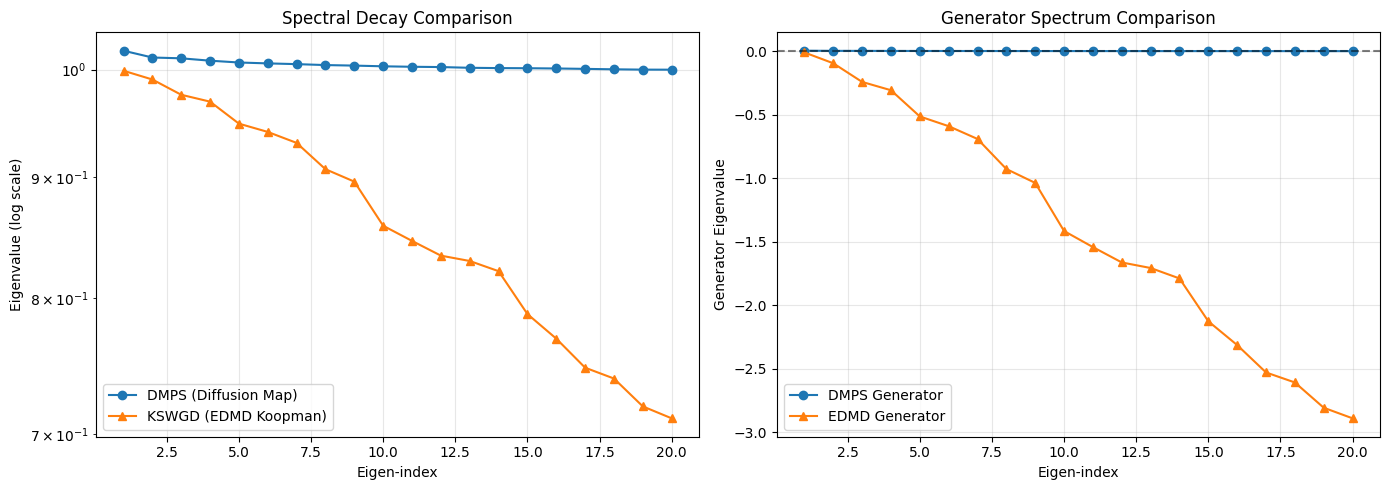


=== Method Comparison ===
DMPS: 300 diffusion map modes
KSWGD: 200 Koopman modes from EDMD


In [18]:
# Compare Diffusion Map (DMPS) and EDMD (KSWGD) spectra
import matplotlib.pyplot as plt

n_show_eigs = 20
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Eigenvalue comparison
ax1 = axes[0]
ax1.semilogy(range(1, n_show_eigs + 1), lambda_ns[:n_show_eigs], 'o-', label="DMPS (Diffusion Map)", markersize=6)
ax1.semilogy(range(1, min(n_show_eigs, lambda_ns_edmd.size) + 1), 
             lambda_ns_edmd[:n_show_eigs], '^-', label="KSWGD (EDMD Koopman)", markersize=6)
ax1.set_xlabel("Eigen-index")
ax1.set_ylabel("Eigenvalue (log scale)")
ax1.set_title("Spectral Decay Comparison")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Generator eigenvalues
ax2 = axes[1]
lambda_gen_dmps = (lambda_ns[:n_show_eigs] - 1.0) / eps_kswgd
ax2.plot(range(1, n_show_eigs + 1), lambda_gen_dmps, 'o-', label="DMPS Generator", markersize=6)
ax2.plot(range(1, min(n_show_eigs, lambda_gen_edmd.size) + 1), 
         lambda_gen_edmd[:n_show_eigs], '^-', label="EDMD Generator", markersize=6)
ax2.set_xlabel("Eigen-index")
ax2.set_ylabel("Generator Eigenvalue")
ax2.set_title("Generator Spectrum Comparison")
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("figures/dmps_vs_kswgd_spectrum.png", dpi=150, bbox_inches='tight')
plt.show()

print("\n=== Method Comparison ===")
print(f"DMPS: {above_tol} diffusion map modes")
print(f"KSWGD: {valid_idx_edmd.size} Koopman modes from EDMD")

In [19]:
# Define unified sampler supporting both DMPS and KSWGD (EDMD) methods
def run_particle_sampler(num_particles=16, num_iters=200, step_size=0.05, rng_seed=42, method="dmps"):
    """
    Unified Particle Transport Sampler
    
    Parameters:
    -----------
    method : str
        "dmps" - Diffusion Map Particle Sampling (uses diffusion map eigenvectors)
        "kswgd" - True KSWGD with EDMD Koopman operator
    """
    rng = np.random.default_rng(rng_seed)
    use_gpu = GPU_KSWGD and torch.cuda.is_available()
    xp = cp if use_gpu else np
    grad_fn = grad_ker1_gpu if use_gpu else grad_ker1
    K_eval_fn = K_tar_eval_gpu if use_gpu else K_tar_eval
    
    method = method.lower()
    if method == "dmps":
        method_name = "DMPS (Diffusion Map)"
        phi_use = phi_trunc
        lambda_use = lambda_ns_s_ns
    elif method == "kswgd":
        method_name = "KSWGD (EDMD Koopman)"
        phi_use = phi_trunc_edmd
        lambda_use = lambda_ns_s_ns_edmd
    else:
        raise ValueError(f"Unknown method: {method}. Use 'dmps' or 'kswgd'.")
    
    print(f"Method: {method_name}")
    print(f"Backend: {'GPU (CuPy)' if use_gpu else 'CPU (NumPy)'}")
    print(f"Eigenfunctions shape: {phi_use.shape}")
    
    x_hist = xp.zeros((num_particles, latent_dim, num_iters), dtype=xp.float64)
    init_particles = rng.normal(0.0, 1.0, size=(num_particles, latent_dim))
    x_hist[:, :, 0] = xp.asarray(init_particles)
    
    if use_gpu:
        X_tar_dev = cp.asarray(X_tar)
        p_tar_dev = cp.asarray(p_tar)
        sq_tar_dev = cp.asarray(sq_tar)
        D_vec_dev = cp.asarray(D_vec)
        phi_dev = cp.asarray(phi_use)
        lambda_dev = cp.asarray(lambda_use)
    else:
        X_tar_dev, p_tar_dev, sq_tar_dev, D_vec_dev = X_tar, p_tar, sq_tar, D_vec
        phi_dev, lambda_dev = phi_use, lambda_use
    
    iterator = trange(num_iters - 1, desc=f"{method.upper()} Transport", unit="step")
    for t in iterator:
        current = x_hist[:, :, t]
        grad_matrix = grad_fn(current, X_tar_dev, p_tar_dev, sq_tar_dev, D_vec_dev, eps_kswgd)
        cross_matrix = K_eval_fn(X_tar_dev, current, p_tar_dev, sq_tar_dev, D_vec_dev, eps_kswgd)
        
        tmp = (phi_dev.T @ cross_matrix) * lambda_dev[:, None]
        push = phi_dev @ tmp
        
        for dim in range(latent_dim):
            sum_term = grad_matrix[:, :, dim] @ push
            x_hist[:, dim, t + 1] = x_hist[:, dim, t] - (step_size / num_particles) * xp.sum(sum_term, axis=1)
        
        if (t + 1) % 50 == 0:
            step_norm = x_hist[:, :, t + 1] - x_hist[:, :, t]
            mean_disp = float(xp.mean(xp.linalg.norm(step_norm, axis=1)))
            iterator.set_postfix({"mean_step": f"{mean_disp:.3e}"})
            if bool(xp.any(xp.isnan(x_hist[:, :, t + 1]))):
                print(f"\nWarning: NaN detected at step {t+1}")
                return np.asarray(xp.asnumpy(x_hist[:, :, t]) if use_gpu else x_hist[:, :, t], dtype=np.float64)
    
    return np.asarray(xp.asnumpy(x_hist[:, :, -1]) if use_gpu else x_hist[:, :, -1], dtype=np.float64)


# Backward compatibility alias
def run_kswgd_sampler(num_particles=16, num_iters=200, step_size=0.05, rng_seed=42):
    """Legacy wrapper - uses DMPS by default for backward compatibility"""
    return run_particle_sampler(num_particles, num_iters, step_size, rng_seed, method="dmps")


def decode_latents_to_images(flat_latents_std):
    """Decode standardized latent vectors to images using MLP AutoEncoder"""
    # 1. De-standardize
    flat_latents = flat_latents_std * Z_std + Z_mean
    
    # 2. MLP AutoEncoder decode (64-dim -> 1024-dim)
    latent_ae.eval()
    with torch.no_grad():
        flat_tensor = torch.from_numpy(flat_latents).float().to(device)
        latents_recovered = latent_ae.decode(flat_tensor).cpu().numpy()
    
    # 3. Reshape to (N, 4, 16, 16)
    latents_tensor = torch.from_numpy(latents_recovered).float().view(-1, *full_latent_shape).to(device)
    
    # 4. VAE decode
    vae.eval()
    with torch.no_grad():
        decoded = vae.decode(latents_tensor / vae_scaling).sample
        decoded_rgb = _from_vae_range(decoded)
    
    return decoded_rgb.cpu()

print("Particle samplers and Decoder defined!")
print(f"  Latent compression: MLP AutoEncoder (1024 -> {REDUCED_DIM})")
print(f"  Available methods:")
print(f"    - 'dmps': Diffusion Map Particle Sampling ({above_tol} modes)")
print(f"    - 'kswgd': EDMD Koopman KSWGD ({valid_idx_edmd.size} modes)")

Particle samplers and Decoder defined!
  Latent compression: MLP AutoEncoder (1024 -> 64)
  Available methods:
    - 'dmps': Diffusion Map Particle Sampling (300 modes)
    - 'kswgd': EDMD Koopman KSWGD (200 modes)


### 7.1 Run Generation: DMPS vs KSWGD Comparison

Now we run both methods and compare results:
- **DMPS**: Diffusion Map Particle Sampling (faster, static kernel)
- **KSWGD**: EDMD-based Koopman Spectral Wasserstein Gradient Descent (learns dynamics)

In [20]:
# ============== Spectral Memory Cleanup ==============
import gc
import sys
import torch
import psutil

print("Starting spectral memory cleanup after eigendecomposition...")

# 1. Record memory usage before cleanup
print("\n=== Memory Usage BEFORE Cleanup ===")
cpu_mem_before = psutil.virtual_memory().used / 1e9
gpu_mem_before = []
for i in range(torch.cuda.device_count()):
    gpu_allocated = torch.cuda.memory_allocated(i) / 1e9
    gpu_reserved = torch.cuda.memory_reserved(i) / 1e9
    gpu_mem_before.append((gpu_allocated, gpu_reserved))
    print(f"GPU {i}: Allocated: {gpu_allocated:.2f} GB, Reserved: {gpu_reserved:.2f} GB")
print(f"CPU RAM: {cpu_mem_before:.2f} GB")

# 2. Calculate and print sizes of variables to be deleted
print(f"\n=== Variables to be Released (max_samples = {max_samples}) ===")
memory_to_release = 0.0
variables_info = {}

# Variables that can be safely deleted after eigendecomposition
deletable_vars = [
    'dists',           # Distance matrix: (max_samples, max_samples) - huge!  
    'data_kernel',     # Original kernel matrix: (max_samples, max_samples)
    'rw_kernel',       # Random walk kernel: (max_samples, max_samples)  
    'phi',             # Full eigenvector matrix (before truncation)
    'lambda_ns',       # Full eigenvalue array (before truncation)
    'Z_flat',          # Original flattened latent vectors
    'all_latents',     # List of latent vectors
    '_eig_result',     # Temporary eigendecomposition results
]

for var in deletable_vars:
    if var in globals():
        obj = globals()[var]
        size_bytes = 0
        if hasattr(obj, 'nbytes'):
            size_bytes = obj.nbytes
        elif hasattr(obj, '__sizeof__'):
            size_bytes = obj.__sizeof__()
        elif isinstance(obj, (list, dict)):
            size_bytes = sys.getsizeof(obj)
            if isinstance(obj, list) and len(obj) > 0:
                # Estimate size for list of arrays
                if hasattr(obj[0], 'nbytes'):
                    size_bytes += sum(item.nbytes for item in obj if hasattr(item, 'nbytes'))
        
        size_gb = size_bytes / 1e9
        memory_to_release += size_gb
        variables_info[var] = size_gb
        print(f"  {var}: {size_gb:.3f} GB")

print(f"Total estimated memory to release: {memory_to_release:.2f} GB")

# 3. Ensure spectral info independence before deletion
print(f"\n=== Ensuring Spectral Data Independence ===")

# Ensure phi_trunc is independent from phi
if 'phi' in globals() and 'phi_trunc' in globals():
    if globals()['phi'] is globals()['phi_trunc']:
        print("⚠️  phi and phi_trunc are the same object - creating independent copy")
        globals()['phi_trunc'] = globals()['phi_trunc'].copy()
        print("✓ Made phi_trunc an independent copy.")
    else:
        print("✓ phi_trunc is already independent from phi")

# 4. Clear Python tracebacks (which can hold references)
sys.last_traceback = None
sys.last_value = None
sys.last_type = None

# 5. Perform the actual deletion
print(f"\n=== Deleting Large Matrices ===")
total_released = 0.0

for var in deletable_vars:
    if var in globals():
        size_gb = variables_info.get(var, 0)
        del globals()[var]
        total_released += size_gb
        print(f"✓ Deleted {var} ({size_gb:.3f} GB)")

# 6. Clean up any remaining CuPy arrays
if 'cp' in dir() and cp is not None:
    cp_vars_found = []
    for name in list(globals().keys()):
        if isinstance(globals().get(name), type(cp.ndarray(1))) if cp is not None else False:
            cp_vars_found.append(name)
            del globals()[name]
    if cp_vars_found:
        print(f"✓ Deleted CuPy arrays from globals: {', '.join(cp_vars_found)}")

# 7. Force memory release
print(f"\n=== Forcing Memory Release ===")
# Python garbage collection
for _ in range(3):
    n_collected = gc.collect()
    if n_collected > 0:
        print(f"✓ Python GC collected {n_collected} objects")

# CuPy memory pool cleanup
if 'cp' in dir() and cp is not None:
    try:
        mempool = cp.get_default_memory_pool()
        pinned_mempool = cp.get_default_pinned_memory_pool()
        
        for _ in range(3):
            mempool.free_all_blocks()
            pinned_mempool.free_all_blocks()
        
        print(f"✓ CuPy memory pool cleared and blocks freed.")
    except Exception as e:
        print(f"✗ CuPy cleanup error: {e}")

# PyTorch cleanup
torch.cuda.empty_cache()
print("✓ PyTorch CUDA cache emptied")

# 8. Record memory usage after cleanup  
print(f"\n=== Memory Usage AFTER Cleanup ===")
cpu_mem_after = psutil.virtual_memory().used / 1e9
gpu_mem_after = []
for i in range(torch.cuda.device_count()):
    gpu_allocated = torch.cuda.memory_allocated(i) / 1e9
    gpu_reserved = torch.cuda.memory_reserved(i) / 1e9
    gpu_mem_after.append((gpu_allocated, gpu_reserved))
    total = torch.cuda.get_device_properties(i).total_memory / 1e9
    print(f"GPU {i}: Allocated: {gpu_allocated:.2f} GB, Reserved: {gpu_reserved:.2f} GB, Free: {total - gpu_allocated:.2f} GB")
print(f"CPU RAM: {cpu_mem_after:.2f} GB")

# 9. Calculate and report memory savings
print(f"\n=== Memory Cleanup Summary ===")
cpu_released = cpu_mem_before - cpu_mem_after
print(f"CPU RAM released: {cpu_released:.2f} GB")

for i in range(len(gpu_mem_before)):
    gpu_released_allocated = gpu_mem_before[i][0] - gpu_mem_after[i][0]  
    gpu_released_reserved = gpu_mem_before[i][1] - gpu_mem_after[i][1]
    print(f"GPU {i} memory released: Allocated: {gpu_released_allocated:.2f} GB, Reserved: {gpu_released_reserved:.2f} GB")

print(f"Estimated variables released: {total_released:.2f} GB")

# 10. Verify essential spectral data is preserved
print(f"\n=== Essential Spectral Data Verification ===")
essential_vars = [
    'phi_trunc',        # Truncated eigenvectors (n_samples, above_tol)
    'lambda_ns_s_ns',   # Processed eigenvalue weights (above_tol,)
    'X_tar',            # Standardized target samples (n_samples, latent_dim)
    'p_tar',            # Target distribution weights (n_samples,)
    'sq_tar',           # Squared sums of target samples (n_samples,) 
    'D_vec',            # Normalization vector (n_samples,)
    'eps_kswgd',        # Kernel bandwidth parameter
    'Z_mean',           # Standardization mean
    'Z_std',            # Standardization std
]

all_essential_ok = True
for var in essential_vars:
    if var in globals():
        obj = globals()[var]
        if hasattr(obj, 'shape'):
            print(f"✓ {var}: shape {obj.shape}, dtype {obj.dtype}")
        else:
            print(f"✓ {var}: {type(obj).__name__} = {obj}")
    else:
        print(f"✗ {var}: MISSING!")
        all_essential_ok = False

if all_essential_ok:
    print(f"\n✅ All essential spectral data preserved! KSWGD sampling can proceed.")
else:
    print(f"\n❌ Some essential data is missing! Check before running KSWGD.")

print(f"\n✅ Spectral memory cleanup complete!")
print(f"   Total estimated release: {total_released:.2f} GB")
print(f"   Kernel matrix ({max_samples}x{max_samples}) and full eigenvectors deleted")
print(f"   Truncated spectral info (k_eig={k_eig}) preserved for KSWGD")

Starting spectral memory cleanup after eigendecomposition...

=== Memory Usage BEFORE Cleanup ===
GPU 0: Allocated: 1.46 GB, Reserved: 1.54 GB
GPU 1: Allocated: 0.05 GB, Reserved: 0.09 GB
CPU RAM: 157.50 GB

=== Variables to be Released (max_samples = 28000) ===
  dists: 6.272 GB
  data_kernel: 6.272 GB
  rw_kernel: 6.272 GB
  phi: 0.034 GB
  lambda_ns: 0.000 GB
  Z_flat: 1.376 GB
  all_latents: 0.000 GB
  _eig_result: 0.000 GB
Total estimated memory to release: 20.23 GB

=== Ensuring Spectral Data Independence ===
✓ phi_trunc is already independent from phi

=== Deleting Large Matrices ===
✓ Deleted dists (6.272 GB)
✓ Deleted data_kernel (6.272 GB)
✓ Deleted rw_kernel (6.272 GB)
✓ Deleted phi (0.034 GB)
✓ Deleted lambda_ns (0.000 GB)
✓ Deleted Z_flat (1.376 GB)
✓ Deleted all_latents (0.000 GB)
✓ Deleted _eig_result (0.000 GB)

=== Forcing Memory Release ===
✓ Python GC collected 7449 objects
✓ CuPy memory pool cleared and blocks freed.
✓ PyTorch CUDA cache emptied

=== Memory Usage AF

In [21]:
# Run KSWGD sampling to generate new latent vectors
kswgd_config = {
    "num_particles": n_generate,  # (n_generate) Same as LDM generation count for fair comparison
    "num_iters": 500,             # Number of iterations
    "step_size": 0.05,            # Step size (smaller for stability)
    "rng_seed": 42
}

print("=" * 50)
print("KSWGD Generation Config:")
for k, v in kswgd_config.items():
    print(f"  {k}: {v}")
print("=" * 50)
print(f"\nNote: Generating {kswgd_config['num_particles']} particles for reliable FID...")
print("This will take a while...")

# Run KSWGD (progress bar is built into run_kswgd_sampler via trange)
start_time = time.time()
Z_kswgd_std = run_kswgd_sampler(**kswgd_config)
kswgd_time = time.time() - start_time

print(f"\n✓ KSWGD Complete!")
print(f"Generated samples shape: {Z_kswgd_std.shape}")
print(f"Total time: {kswgd_time:.1f} seconds ({kswgd_time/60:.1f} minutes)")

KSWGD Generation Config:
  num_particles: 2
  num_iters: 500
  step_size: 0.05
  rng_seed: 42

Note: Generating 2 particles for reliable FID...
This will take a while...
Method: DMPS (Diffusion Map)
Backend: GPU (CuPy)
Eigenfunctions shape: (28000, 300)


DMPS Transport: 100%|██████████| 499/499 [00:06<00:00, 83.16step/s, mean_step=9.549e-08]


✓ KSWGD Complete!
Generated samples shape: (2, 64)
Total time: 6.3 seconds (0.1 minutes)


In [22]:
# Decode KSWGD generated latent vectors to images (in batches to avoid OOM)
print(f"Decoding {Z_kswgd_std.shape[0]} latent vectors to images...")

decode_batch_size = 128  # Increased for 80GB GPUs
all_kswgd_images = []

for i in tqdm(range(0, Z_kswgd_std.shape[0], decode_batch_size), desc="Decoding KSWGD"):
    batch_latents = Z_kswgd_std[i:i+decode_batch_size]
    batch_images = decode_latents_to_images(batch_latents)
    all_kswgd_images.append(batch_images.numpy())
    
    # Clear cache periodically
    if (i // decode_batch_size + 1) % 20 == 0:
        torch.cuda.empty_cache()

kswgd_images_np = np.concatenate(all_kswgd_images, axis=0)

print(f"\n✓ Decoding complete!")
print(f"Generated images shape: {kswgd_images_np.shape}")
print(f"Pixel value range: [{kswgd_images_np.min():.3f}, {kswgd_images_np.max():.3f}]")

Decoding 2 latent vectors to images...


Decoding KSWGD: 100%|██████████| 1/1 [00:00<00:00, 16.67it/s]


✓ Decoding complete!
Generated images shape: (2, 3, 256, 256)
Pixel value range: [0.010, 0.918]


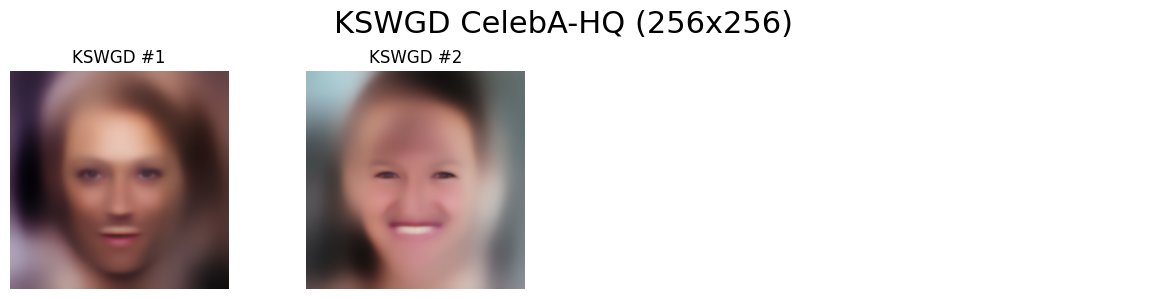


Generation Summary:
  - LDM: 2 images via UNet Denoising (200 steps)
  - KSWGD: 2 images via KSWGD (500 steps)


In [23]:
# Visualize KSWGD generated images (show first 16 of 10000)
n_show = min(16, kswgd_images_np.shape[0])
n_cols = 4
n_rows = (n_show + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
axes = np.asarray(axes).reshape(-1)

for idx in range(n_show):
    img = np.transpose(kswgd_images_np[idx], (1, 2, 0))  # (C,H,W) → (H,W,C)
    axes[idx].imshow(np.clip(img, 0.0, 1.0))
    axes[idx].set_title(f"KSWGD #{idx+1}")
    axes[idx].axis('off')

for idx in range(n_show, len(axes)):
    axes[idx].axis('off')

# Get image size from KSWGD generated images (shape is N, C, H, W)
_kswgd_img_size = kswgd_images_np.shape[2]
plt.suptitle(f"KSWGD CelebA-HQ ({_kswgd_img_size}x{_kswgd_img_size})", fontsize=22)
plt.tight_layout()
plt.show()

print(f"\nGeneration Summary:")
print(f"  - LDM: {len(ldm_generated_images)} images via UNet Denoising (200 steps)")
print(f"  - KSWGD: {kswgd_images_np.shape[0]} images via KSWGD ({kswgd_config['num_iters']} steps)")

Upscaling KSWGD Generated Images with GFPGAN
(with preprocessing: Gaussian + Bilateral + Color Norm)

Enhancing 2 KSWGD images with preprocessing + GFPGAN...
  Using Dual-GPU parallel processing...


Preprocess+GFPGAN (KSWGD) (GPU 1): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


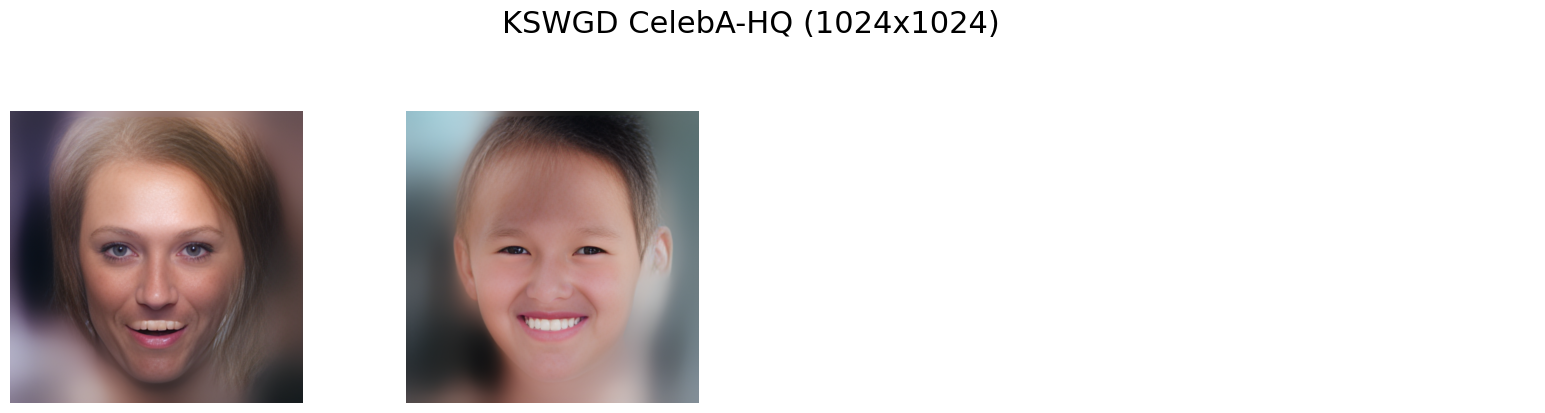


✓ KSWGD Enhancement complete!
  Original KSWGD: 256x256
  Enhanced: 1024x1024
  Preprocessing applied: Gaussian blur (3x3, σ=0.5) + Bilateral (d=5) + Color norm (α=0.3)


In [24]:
# ============== Apply GFPGAN to KSWGD Generated Images ==============
print("=" * 60)
print("Upscaling KSWGD Generated Images with GFPGAN")
print("(with preprocessing: Gaussian + Bilateral + Color Norm)")
print("=" * 60)

# Convert KSWGD images to the right format for upscaling
kswgd_images_for_upscale = []
for i in range(kswgd_images_np.shape[0]):
    img = np.transpose(kswgd_images_np[i], (1, 2, 0))  # (C,H,W) → (H,W,C)
    img = np.clip(img, 0, 1)
    kswgd_images_for_upscale.append(img)

print(f"\nEnhancing {len(kswgd_images_for_upscale)} KSWGD images with preprocessing + GFPGAN...")
kswgd_enhanced = upscale_images(kswgd_images_for_upscale, use_face_enhance=True, use_preprocess=True, desc="Preprocess+GFPGAN (KSWGD)")

# Visualization (show up to 16 in a grid)
n_test_kswgd = len(kswgd_enhanced)
n_show_kswgd = min(16, n_test_kswgd)
n_cols = 4
n_rows = (n_show_kswgd + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = np.asarray(axes).reshape(-1)

for i in range(n_show_kswgd):
    axes[i].imshow(kswgd_enhanced[i])
    # axes[i].set_title(f"#{i+1}")
    axes[i].axis('off')

for i in range(n_show_kswgd, len(axes)):
    axes[i].axis('off')

# Get image size from enhanced images
_kswgd_enhanced_size = kswgd_enhanced[0].shape[1] if isinstance(kswgd_enhanced[0], np.ndarray) else kswgd_enhanced[0].size[0]
plt.suptitle(f"KSWGD CelebA-HQ ({_kswgd_enhanced_size}x{_kswgd_enhanced_size})\n", fontsize=22, y=1.02)
plt.tight_layout()
plt.savefig('/workspace/kswgd/figures/kswgd_gfpgan_enhanced.png', dpi=150, bbox_inches='tight')
plt.show()

# Store enhanced KSWGD images
kswgd_upscaled = kswgd_enhanced

print(f"\n✓ KSWGD Enhancement complete!")
print(f"  Original KSWGD: 256x256")
print(f"  Enhanced: {kswgd_upscaled[0].shape[1]}x{kswgd_upscaled[0].shape[0]}")
print(f"  Preprocessing applied: Gaussian blur (3x3, σ=0.5) + Bilateral (d=5) + Color norm (α=0.3)")

### 7.2 FID (Fréchet Inception Distance) Evaluation

Compute FID scores to quantitatively compare LDM and KSWGD generation quality.

**FID** measures the distance between the distribution of generated images and real images in Inception-v3 feature space. **Lower is better.**

In [25]:
# ============== FID Utility Functions (Dual-GPU Support) ==============
# Install pytorch-fid if needed
import subprocess
import sys
from concurrent.futures import ThreadPoolExecutor

try:
    from pytorch_fid import fid_score
    from pytorch_fid.inception import InceptionV3
except ImportError:
    print("Installing pytorch-fid...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pytorch-fid", "-q"])
    from pytorch_fid import fid_score
    from pytorch_fid.inception import InceptionV3

from scipy import linalg
from torchvision import transforms as T

# Check number of GPUs for FID computation
NUM_GPUS_FID = torch.cuda.device_count()
USE_DUAL_GPU_FID = NUM_GPUS_FID >= 2
print(f"FID computation: Detected {NUM_GPUS_FID} GPU(s), using {'Dual-GPU' if USE_DUAL_GPU_FID else 'Single-GPU'} mode")

def get_inception_features_single_gpu(images, gpu_id, batch_size=256, desc="Extracting features"):
    """Extract Inception-v3 features on a single GPU"""
    device_local = torch.device(f"cuda:{gpu_id}")
    
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
    inception = InceptionV3([block_idx]).to(device_local)
    inception.eval()
    
    preprocess = T.Compose([
        T.Resize((299, 299)),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    features_list = []
    n_batches = (len(images) + batch_size - 1) // batch_size
    
    with torch.no_grad():
        for i in tqdm(range(0, len(images), batch_size), total=n_batches, desc=f"{desc} (GPU {gpu_id})"):
            batch_samples = images[i:i+batch_size]
            
            tensors = []
            for img in batch_samples:
                if isinstance(img, Image.Image):
                    t = T.ToTensor()(img)
                elif isinstance(img, np.ndarray):
                    t = torch.from_numpy(img).float()
                    if t.ndim == 3:
                        if t.shape[2] == 3 and t.shape[0] != 3:
                            t = t.permute(2, 0, 1)
                    if t.max() > 1.0: t /= 255.0
                else:
                    t = torch.as_tensor(img).float()
                tensors.append(t)
            
            batch = torch.stack(tensors).to(device_local)
            batch = preprocess(batch)
            feat = inception(batch)[0]
            feat = feat.squeeze(-1).squeeze(-1)
            features_list.append(feat.cpu().numpy())
    
    del inception
    torch.cuda.empty_cache()
    
    return np.concatenate(features_list, axis=0)

def get_inception_features(images, batch_size=256, desc="Extracting features"):
    """
    Extract Inception-v3 features from images.
    Automatically uses dual-GPU parallel processing if available.
    """
    n_images = len(images)
    
    if USE_DUAL_GPU_FID and n_images >= 64:  # Only use dual-GPU for larger batches
        print(f"  Using Dual-GPU parallel feature extraction...")
        mid = n_images // 2
        
        images_gpu0 = images[:mid] if isinstance(images, list) else list(images[:mid])
        images_gpu1 = images[mid:] if isinstance(images, list) else list(images[mid:])
        
        # Use ThreadPoolExecutor to run both GPUs in parallel
        with ThreadPoolExecutor(max_workers=2) as executor:
            future_gpu0 = executor.submit(
                get_inception_features_single_gpu, images_gpu0, 0, batch_size, desc
            )
            future_gpu1 = executor.submit(
                get_inception_features_single_gpu, images_gpu1, 1, batch_size, desc
            )
            
            features_gpu0 = future_gpu0.result()
            features_gpu1 = future_gpu1.result()
        
        return np.concatenate([features_gpu0, features_gpu1], axis=0)
    else:
        # Single-GPU processing
        return get_inception_features_single_gpu(images, 0, batch_size, desc)

def calculate_fid(real_features, gen_features):
    """Calculate FID between two sets of features"""
    mu_real = np.mean(real_features, axis=0)
    mu_gen = np.mean(gen_features, axis=0)
    sigma_real = np.cov(real_features, rowvar=False)
    sigma_gen = np.cov(gen_features, rowvar=False)
    
    # Calculate FID
    diff = mu_real - mu_gen
    # Add a small value to diagonal for stability
    offset = np.eye(sigma_real.shape[0]) * 1e-6
    covmean, _ = linalg.sqrtm((sigma_real + offset) @ (sigma_gen + offset), disp=False)
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = diff @ diff + np.trace(sigma_real + sigma_gen - 2 * covmean)
    return float(fid)

print("✓ FID utility functions defined (with Dual-GPU support).")

FID computation: Detected 2 GPU(s), using Dual-GPU mode
✓ FID utility functions defined (with Dual-GPU support).


In [26]:
# ============== FID Evaluation (Raw 256x256 Images) ==============
print("=" * 60)
print("Computing FID Scores (on Raw 256x256 Images)...")
print(f"  LDM raw:   {len(ldm_generated_images)} images")
print(f"  KSWGD raw: {len(kswgd_images_np)} images")
print("=" * 60)

# 1. Get real images from CelebA-HQ (resized to 256x256)
n_real_samples = min(10000, len(celebahq_dataset))  # 10k real images for reliable FID
real_images_256 = []
for i in tqdm(range(n_real_samples), desc="Loading real images (256)"):
    img = celebahq_dataset[i]["image"].resize((256, 256))
    real_images_256.append(np.array(img))

print(f"  Real images loaded: {len(real_images_256)}")

# 2. Extract features
print("\n[1/3] Extracting Inception features from real images (256)...")
real_features_256 = get_inception_features(real_images_256, desc="Real images (256)")

print("\n[2/3] Extracting Inception features from LDM raw images (256)...")
ldm_features_256 = get_inception_features(ldm_generated_images, desc="LDM Raw (256)")

print("\n[3/3] Extracting Inception features from KSWGD raw images (256)...")
kswgd_features_256 = get_inception_features(kswgd_images_np, desc="KSWGD Raw (256)")

# 3. Calculate FID
print("\nCalculating FID scores...")
fid_ldm_raw = calculate_fid(real_features_256, ldm_features_256)
fid_kswgd_raw = calculate_fid(real_features_256, kswgd_features_256)

print("\n" + "=" * 60)
print("FID RESULTS (Raw 256x256, Lower is Better)")
print("=" * 60)
print(f"  Real images:  {n_real_samples}")
print(f"  LDM (Raw):   {len(ldm_generated_images)} → FID = {fid_ldm_raw:.2f}")
print(f"  KSWGD (Raw): {len(kswgd_images_np)} → FID = {fid_kswgd_raw:.2f}")
print("=" * 60)
print(f"\nNote: This FID measures the quality of the raw 256x256 generation before any enhancement.")

Computing FID Scores (on Raw 256x256 Images)...
  LDM raw:   2 images
  KSWGD raw: 2 images


Loading real images (256): 100%|██████████| 10000/10000 [01:57<00:00, 84.81it/s]


  Real images loaded: 10000

[1/3] Extracting Inception features from real images (256)...
  Using Dual-GPU parallel feature extraction...


Real images (256) (GPU 1): 100%|██████████| 20/20 [00:17<00:00,  1.12it/s]



[2/3] Extracting Inception features from LDM raw images (256)...


LDM Raw (256) (GPU 0): 100%|██████████| 1/1 [00:00<00:00, 20.44it/s]



[3/3] Extracting Inception features from KSWGD raw images (256)...


KSWGD Raw (256) (GPU 0): 100%|██████████| 1/1 [00:00<00:00, 73.38it/s]



Calculating FID scores...


/tmp/ipykernel_43304/3916039828.py:111: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm((sigma_real + offset) @ (sigma_gen + offset), disp=False)



FID RESULTS (Raw 256x256, Lower is Better)
  Real images:  10000
  LDM (Raw):   2 → FID = 235.44
  KSWGD (Raw): 2 → FID = 267.64

Note: This FID measures the quality of the raw 256x256 generation before any enhancement.


In [27]:
# ============== FID Evaluation (Enhanced 1024x1024 Images) ==============
print("=" * 60)
print("Computing FID Scores (on 1024x1024 Enhanced Images)...")
print(f"  LDM enhanced:   {len(ldm_upscaled)} images")
print(f"  KSWGD enhanced: {len(kswgd_upscaled)} images")
print("=" * 60)

# 1. Get real images from CelebA-HQ (1024x1024)
print("\n[1/4] Loading real CelebA-HQ images (1024x1024)...")
# Use a smaller number for real images if memory is tight, but 1000-2000 is usually enough for comparison
n_real_samples = min(10000, len(celebahq_dataset))  # 10k real images for reliable FID
real_images_1024 = []
for i in tqdm(range(n_real_samples), desc="Loading real images (1024)"):
    img = celebahq_dataset[i]["image"]
    # No resize, keep original 1024x1024
    img_tensor = T.ToTensor()(img) 
    real_images_1024.append(img_tensor.numpy())

print(f"  Real images loaded: {len(real_images_1024)}")

print("\n[2/4] Extracting Inception features from real images (1024)...")
real_features_1024 = get_inception_features(real_images_1024, desc="Real images (1024)")

# 2. Get LDM enhanced images features
print("\n[3/4] Extracting Inception features from LDM enhanced images...")
ldm_features_1024 = get_inception_features(ldm_upscaled, desc="LDM Enhanced")

# 3. Get KSWGD enhanced images features  
print("\n[4/4] Extracting Inception features from KSWGD enhanced images...")
kswgd_features_1024 = get_inception_features(kswgd_upscaled, desc="KSWGD Enhanced")

# 4. Calculate FID scores
print("\nCalculating FID scores...")
fid_ldm_enhanced = calculate_fid(real_features_1024, ldm_features_1024)
fid_kswgd_enhanced = calculate_fid(real_features_1024, kswgd_features_1024)

print("\n" + "=" * 60)
print("FID RESULTS (Enhanced 1024x1024, Lower is Better)")
print("=" * 60)
print(f"  Real images:  {n_real_samples}")
print(f"  LDM (Enhanced):   {len(ldm_upscaled)} → FID = {fid_ldm_enhanced:.2f}")
print(f"  KSWGD (Enhanced): {len(kswgd_upscaled)} → FID = {fid_kswgd_enhanced:.2f}")
print("=" * 60)
print(f"\nNote: This FID measures the quality of the full pipeline (Model + Preprocessing + GFPGAN).")

Computing FID Scores (on 1024x1024 Enhanced Images)...
  LDM enhanced:   2 images
  KSWGD enhanced: 2 images

[1/4] Loading real CelebA-HQ images (1024x1024)...


Loading real images (1024): 100%|██████████| 10000/10000 [03:04<00:00, 54.19it/s]


  Real images loaded: 10000

[2/4] Extracting Inception features from real images (1024)...
  Using Dual-GPU parallel feature extraction...


Real images (1024) (GPU 1): 100%|██████████| 20/20 [00:44<00:00,  2.21s/it]



[3/4] Extracting Inception features from LDM enhanced images...


LDM Enhanced (GPU 0): 100%|██████████| 1/1 [00:00<00:00, 39.60it/s]



[4/4] Extracting Inception features from KSWGD enhanced images...


KSWGD Enhanced (GPU 0): 100%|██████████| 1/1 [00:00<00:00, 44.36it/s]



Calculating FID scores...


/tmp/ipykernel_43304/3916039828.py:111: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm((sigma_real + offset) @ (sigma_gen + offset), disp=False)



FID RESULTS (Enhanced 1024x1024, Lower is Better)
  Real images:  10000
  LDM (Enhanced):   2 → FID = 242.68
  KSWGD (Enhanced): 2 → FID = 295.30

Note: This FID measures the quality of the full pipeline (Model + Preprocessing + GFPGAN).


## 9. Clean Up GPU Memory

In [28]:
# Clean up GPU memory
import gc

if 'ldm_pipe' in dir():
    del ldm_pipe
if 'vae' in dir():
    del vae
gc.collect()
torch.cuda.empty_cache()

print(f"Current GPU memory usage: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print(f"GPU memory cached: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

Current GPU memory usage: 1.25 GB
GPU memory cached: 1.54 GB
